# House Price Prediction - Optimized Version

## 项目概述

本notebook是对原始房价预测模型的优化版本，主要改进包括：

1. **更完善的数据探索分析(EDA)**：增加了目标变量分布、特征分布、相关性分析、异常值检测等多个维度的可视化
2. **优化的特征工程**：改进了缺失值处理策略、特征交互和衍生特征构造
3. **增强的模型集成**：优化了模型参数和集成策略
4. **清晰的代码结构**：将可视化代码自然地分散到各个分析步骤中，便于理解和维护

---

## 1. 导入必要的库

In [1]:
# 基础数据处理库
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习库
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# XGBoost
try:
    import xgboost as xgb
except ImportError:
    print('XGBoost not installed, will skip XGBoost model')

# 统计分析
import scipy.stats as stats

# 设置随机种子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 设置绘图样式
sns.set_style('whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print('所有库导入成功！')

所有库导入成功！


## 2. 数据加载

加载训练集和测试集数据，设置目标变量为 SalePrice。

In [2]:
# 数据读取函数
def read_first_exist(candidates, required=True):
    """尝试从候选路径列表中读取第一个存在的文件"""
    for p in candidates:
        if os.path.exists(p):
            print(f'读取文件: {p}')
            return pd.read_csv(p)
    if required:
        raise FileNotFoundError(f'未找到任何候选文件: {candidates}')
    return None

# 定义目标变量
TARGET = 'SalePrice'

# 读取数据
train = read_first_exist([
    '/kaggle/input/house-prices-advanced-regression-techniques/train.csv',
    './data/train.csv',
    './train.csv'
], required=True)

test = read_first_exist([
    '/kaggle/input/house-prices-advanced-regression-techniques/test.csv',
    './data/test.csv',
    './test.csv'
], required=True)

# 提取目标变量
y = train[TARGET].copy()
y_log = np.log1p(y)  # log变换后的目标变量

print(f'训练集形状: {train.shape}')
print(f'测试集形状: {test.shape}')
print(f'目标变量: {TARGET}')

读取文件: ./train.csv
读取文件: ./test.csv
训练集形状: (1460, 81)
测试集形状: (1459, 80)
目标变量: SalePrice


In [3]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


## 3. 数据概览与初步分析

首先查看数据的基本信息，包括形状、数据类型、缺失值等。

In [5]:
# 数据基本信息
print('='*80)
print('训练集基本信息')
print('='*80)
print(f'数据形状: {train.shape[0]} 行 × {train.shape[1]} 列')
print(f'内存占用: {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
print(f'\n前5行数据:')
display(train.head())

# 统计数值特征和类别特征
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train.select_dtypes(include=['object']).columns.tolist()

if TARGET in numeric_features:
    numeric_features.remove(TARGET)
if 'Id' in numeric_features:
    numeric_features.remove('Id')

print(f'\n特征类型统计:')
print(f'  数值特征数量: {len(numeric_features)}')
print(f'  类别特征数量: {len(categorical_features)}')
print(f'  总特征数量: {len(numeric_features) + len(categorical_features)}')

训练集基本信息
数据形状: 1460 行 × 81 列
内存占用: 3.86 MB

前5行数据:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



特征类型统计:
  数值特征数量: 36
  类别特征数量: 43
  总特征数量: 79


### 3.1 目标变量分析

分析目标变量 SalePrice 的分布特征，包括原始分布和 log 变换后的分布。
Log 变换可以：
1. 减少数据的偏度，使分布更接近正态分布
2. 降低极端值的影响
3. 使得模型预测更加稳定

目标变量统计信息:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

偏度 (Skewness): 1.8829
峰度 (Kurtosis): 6.5363


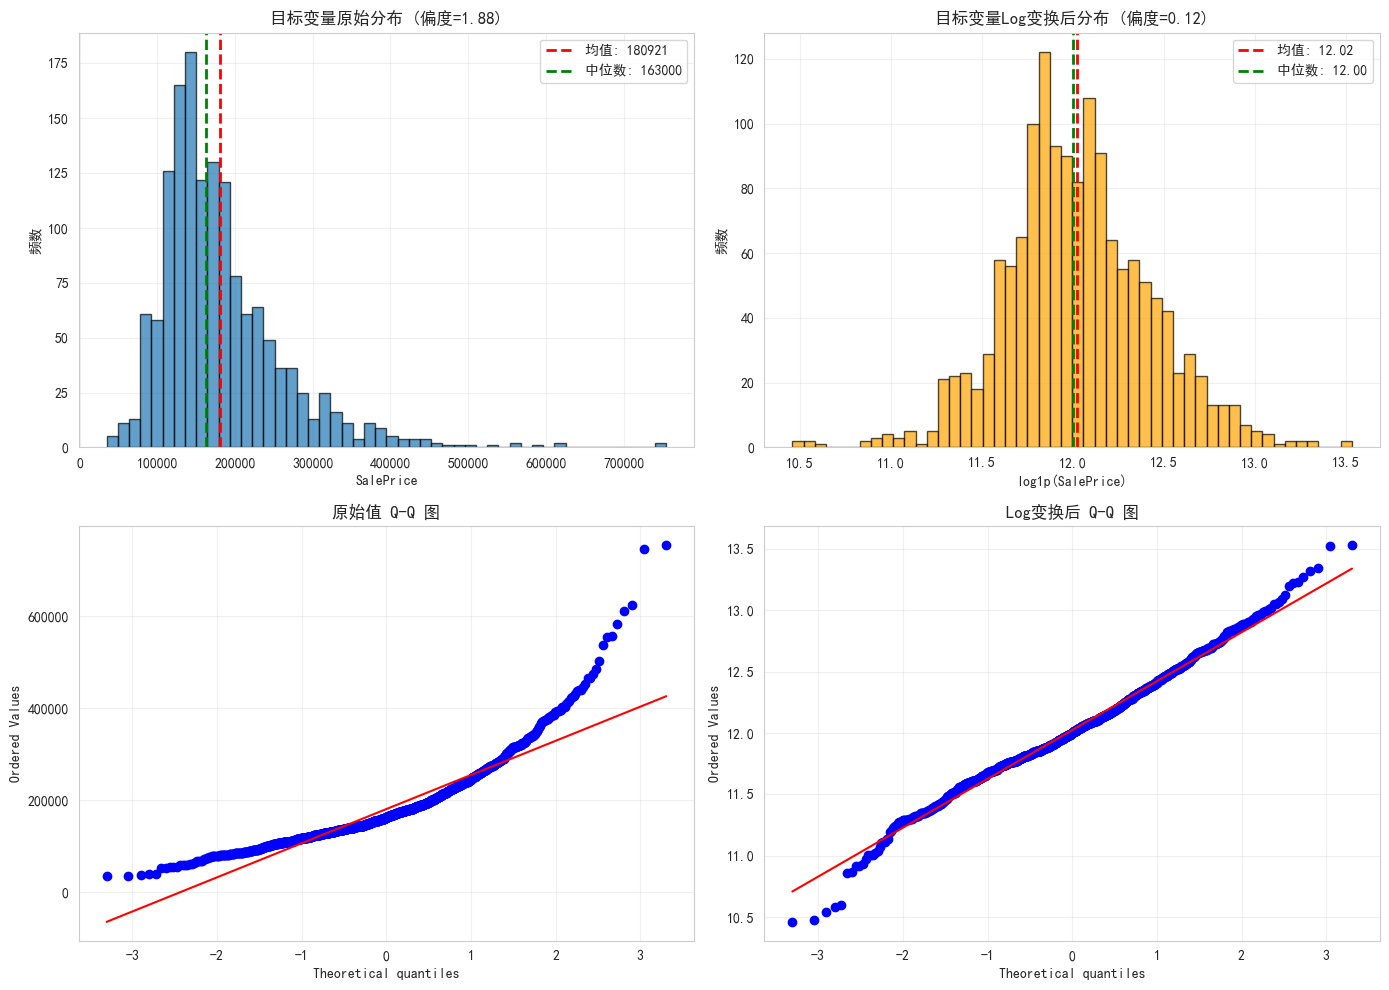


分析结论:
1. 原始 SalePrice 呈现右偏分布，存在较多高价房产
2. Log 变换后分布更接近正态分布，Q-Q 图上点更贴近对角线
3. 使用 log 变换后的目标变量进行建模可以提高模型性能


In [6]:
# 目标变量统计信息
print('目标变量统计信息:')
print(y.describe())
print(f'\n偏度 (Skewness): {y.skew():.4f}')
print(f'峰度 (Kurtosis): {y.kurtosis():.4f}')

# 可视化目标变量分布
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 原始分布 - 直方图
axes[0, 0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'均值: {y.mean():.0f}')
axes[0, 0].axvline(y.median(), color='green', linestyle='--', linewidth=2, label=f'中位数: {y.median():.0f}')
axes[0, 0].set_xlabel('SalePrice')
axes[0, 0].set_ylabel('频数')
axes[0, 0].set_title(f'目标变量原始分布 (偏度={y.skew():.2f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Log变换后的分布 - 直方图
axes[0, 1].hist(y_log, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].axvline(y_log.mean(), color='red', linestyle='--', linewidth=2, label=f'均值: {y_log.mean():.2f}')
axes[0, 1].axvline(y_log.median(), color='green', linestyle='--', linewidth=2, label=f'中位数: {y_log.median():.2f}')
axes[0, 1].set_xlabel('log1p(SalePrice)')
axes[0, 1].set_ylabel('频数')
axes[0, 1].set_title(f'目标变量Log变换后分布 (偏度={y_log.skew():.2f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# QQ图 - 原始值
stats.probplot(y, dist='norm', plot=axes[1, 0])
axes[1, 0].set_title('原始值 Q-Q 图')
axes[1, 0].grid(True, alpha=0.3)

# QQ图 - Log变换后
stats.probplot(y_log, dist='norm', plot=axes[1, 1])
axes[1, 1].set_title('Log变换后 Q-Q 图')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n分析结论:')
print('1. 原始 SalePrice 呈现右偏分布，存在较多高价房产')
print('2. Log 变换后分布更接近正态分布，Q-Q 图上点更贴近对角线')
print('3. 使用 log 变换后的目标变量进行建模可以提高模型性能')

### 3.2 缺失值分析

分析训练集和测试集的缺失值情况，找出缺失严重的特征。

In [7]:
# 缺失值统计函数
def analyze_missing_values(df, name='Dataset'):
    """分析并可视化缺失值"""
    total_missing = df.isnull().sum()
    percent_missing = (total_missing / len(df)) * 100
    
    missing_df = pd.DataFrame({
        '特征': df.columns,
        '缺失数量': total_missing.values,
        '缺失比例(%)': percent_missing.values
    })
    
    missing_df = missing_df[missing_df['缺失数量'] > 0].sort_values('缺失比例(%)', ascending=False)
    
    print(f'\n{name} 缺失值统计:')
    print(f'总缺失值数量: {total_missing.sum()}')
    print(f'总缺失值比例: {(total_missing.sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%')
    print(f'有缺失值的特征数: {len(missing_df)}')
    
    return missing_df

# 分析训练集缺失值
train_missing = analyze_missing_values(train, '训练集')
test_missing = analyze_missing_values(test, '测试集')

print('\n训练集缺失值最严重的前10个特征:')
display(train_missing.head(10))


训练集 缺失值统计:
总缺失值数量: 7829
总缺失值比例: 6.62%
有缺失值的特征数: 19

测试集 缺失值统计:
总缺失值数量: 7878
总缺失值比例: 6.75%
有缺失值的特征数: 33

训练集缺失值最严重的前10个特征:


,特征,缺失数量,缺失比例(%)
72,PoolQC,1453,99.520548
74,MiscFeature,1406,96.301370
6,Alley,1369,93.767123
73,Fence,1179,80.753425
25,MasVnrType,872,59.726027
57,FireplaceQu,690,47.260274
3,LotFrontage,259,17.739726
58,GarageType,81,5.547945
59,GarageYrBlt,81,5.547945
60,GarageFinish,81,5.547945


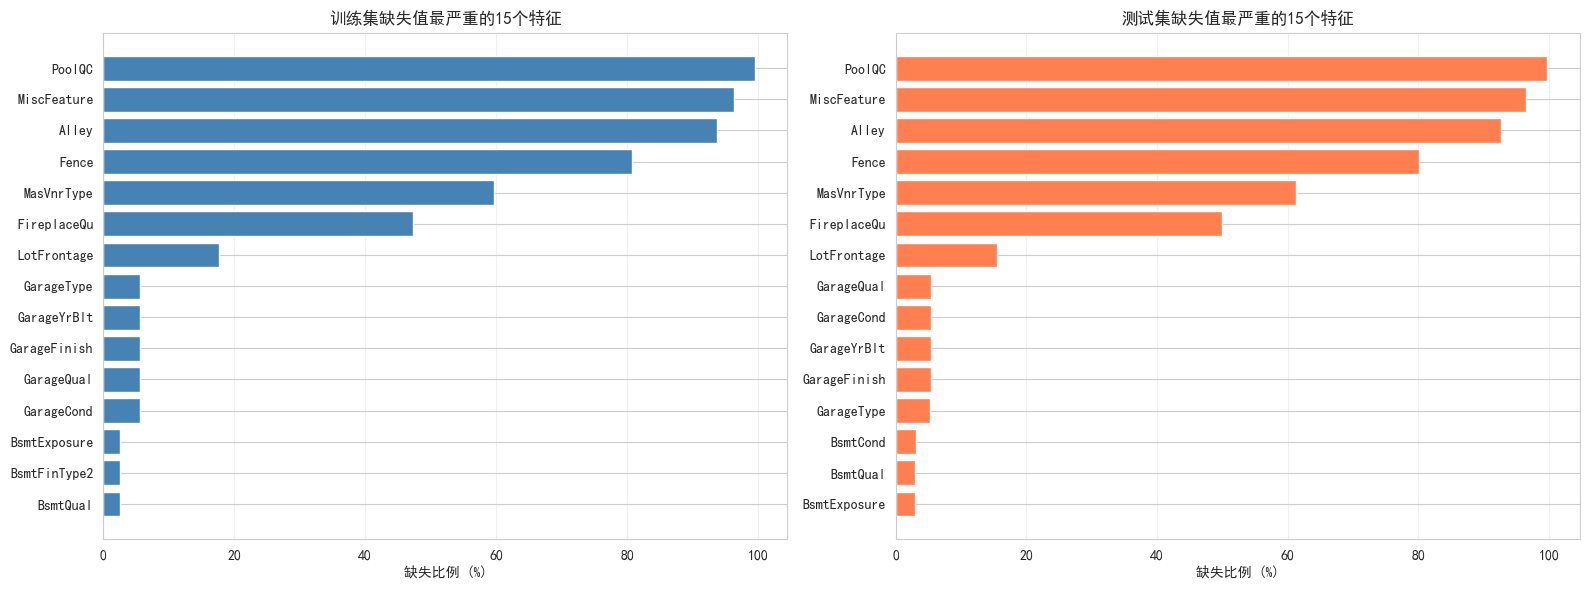


缺失值分析结论:
1. PoolQC, MiscFeature, Alley等特征缺失率很高(>90%), 可能需要删除或特殊处理
2. Fence, FireplaceQu等特征缺失率中等(40-80%), 缺失可能代表无该设施
3. LotFrontage等特征缺失率较低，可以考虑填充


In [8]:
# 可视化缺失值分布
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 训练集缺失值Top 15
top_n = min(15, len(train_missing))
if top_n > 0:
    axes[0].barh(range(top_n), train_missing.head(top_n)['缺失比例(%)'].values, color='steelblue')
    axes[0].set_yticks(range(top_n))
    axes[0].set_yticklabels(train_missing.head(top_n)['特征'].values)
    axes[0].set_xlabel('缺失比例 (%)')
    axes[0].set_title(f'训练集缺失值最严重的{top_n}个特征')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')

# 测试集缺失值Top 15
top_n_test = min(15, len(test_missing))
if top_n_test > 0:
    axes[1].barh(range(top_n_test), test_missing.head(top_n_test)['缺失比例(%)'].values, color='coral')
    axes[1].set_yticks(range(top_n_test))
    axes[1].set_yticklabels(test_missing.head(top_n_test)['特征'].values)
    axes[1].set_xlabel('缺失比例 (%)')
    axes[1].set_title(f'测试集缺失值最严重的{top_n_test}个特征')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print('\n缺失值分析结论:')
print('1. PoolQC, MiscFeature, Alley等特征缺失率很高(>90%), 可能需要删除或特殊处理')
print('2. Fence, FireplaceQu等特征缺失率中等(40-80%), 缺失可能代表无该设施')
print('3. LotFrontage等特征缺失率较低，可以考虑填充')

### 3.3 数值特征分析

选择重要的数值特征进行分布分析，了解其统计特性。

重要数值特征统计信息:


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0,2.163569,17.452867
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0,12.207688,203.243271
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0,0.216944,0.096293
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0,0.693067,1.106413
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0,-0.613461,-0.439552
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0,-0.503562,-1.272245
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0,1.524255,13.250483
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.50,1464.0,1776.75,5642.0,1.366560,4.895121
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0,1.376757,5.745841
GarageArea,1460.0,472.980137,213.804841,0.0,334.50,480.0,576.00,1418.0,0.179981,0.917067


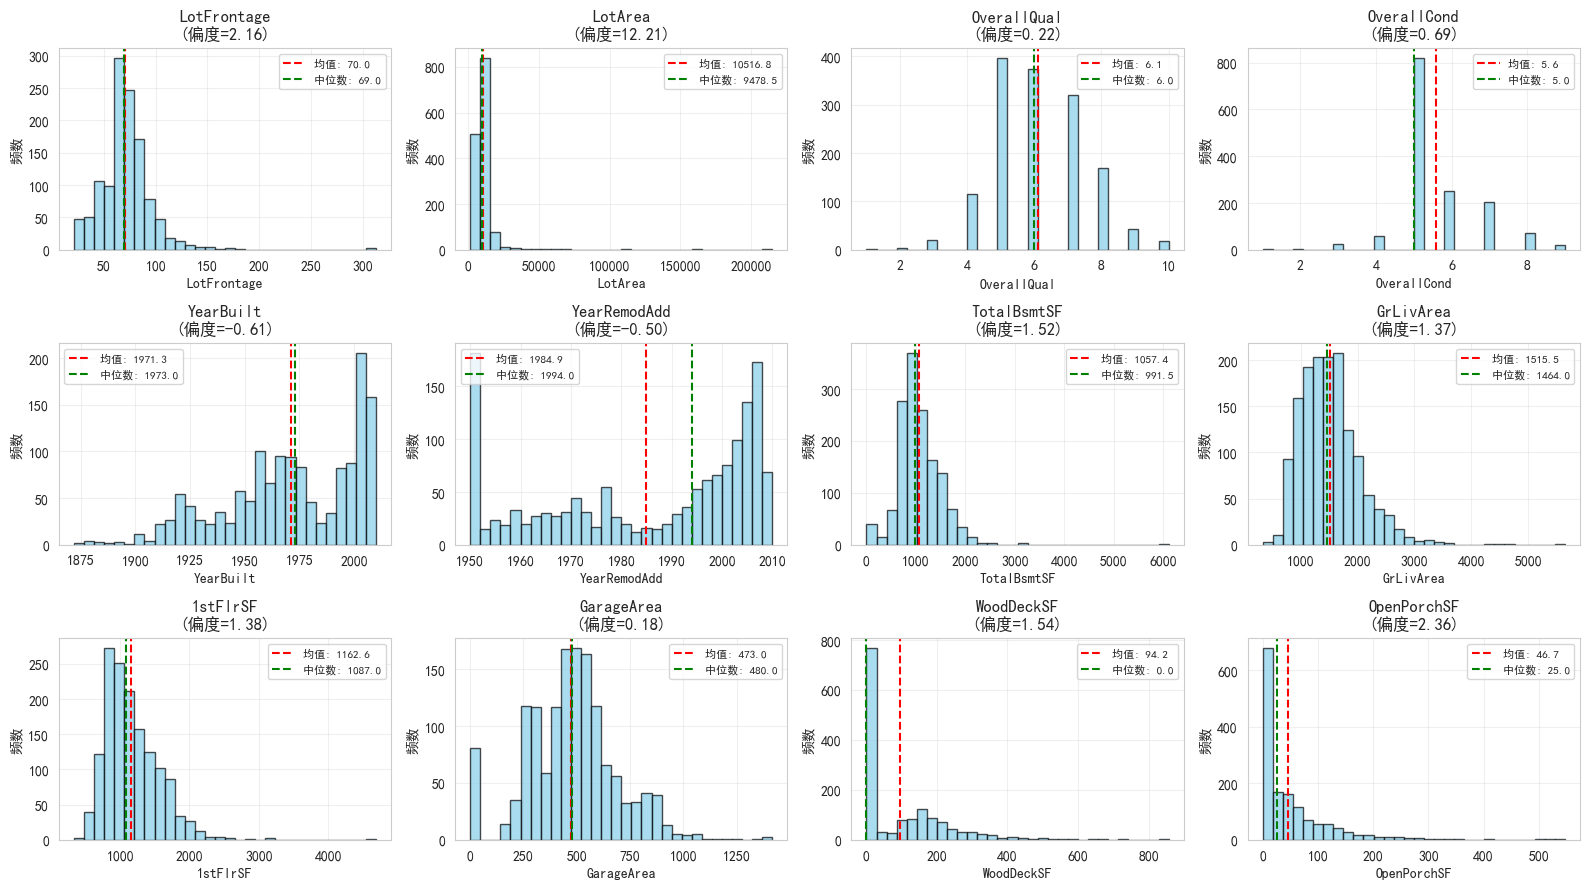


数值特征分析结论:
1. LotArea, GrLivArea等面积特征呈现右偏分布，存在异常值
2. OverallQual和OverallCond是离散评分特征，分布相对均匀
3. 年份特征(YearBuilt, YearRemodAdd)呈现左偏分布，大部分房屋较新


In [9]:
# 选择重要的数值特征进行可视化
important_numeric = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
    'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea',
    '1stFlrSF', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'
]

# 确保特征存在
important_numeric = [f for f in important_numeric if f in train.columns]

# 计算这些特征的统计信息
print('重要数值特征统计信息:')
stats_df = train[important_numeric].describe().T
stats_df['skewness'] = train[important_numeric].skew()
stats_df['kurtosis'] = train[important_numeric].kurtosis()
display(stats_df)

# 可视化分布
n_features = len(important_numeric)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(important_numeric):
    ax = axes[idx]
    data = train[feature].dropna()
    
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=1.5, label=f'均值: {data.mean():.1f}')
    ax.axvline(data.median(), color='green', linestyle='--', linewidth=1.5, label=f'中位数: {data.median():.1f}')
    ax.set_xlabel(feature)
    ax.set_ylabel('频数')
    ax.set_title(f'{feature}\n(偏度={data.skew():.2f})')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# 隐藏多余的子图
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print('\n数值特征分析结论:')
print('1. LotArea, GrLivArea等面积特征呈现右偏分布，存在异常值')
print('2. OverallQual和OverallCond是离散评分特征，分布相对均匀')
print('3. 年份特征(YearBuilt, YearRemodAdd)呈现左偏分布，大部分房屋较新')

### 3.4 类别特征分析

分析重要类别特征的分布和频次。

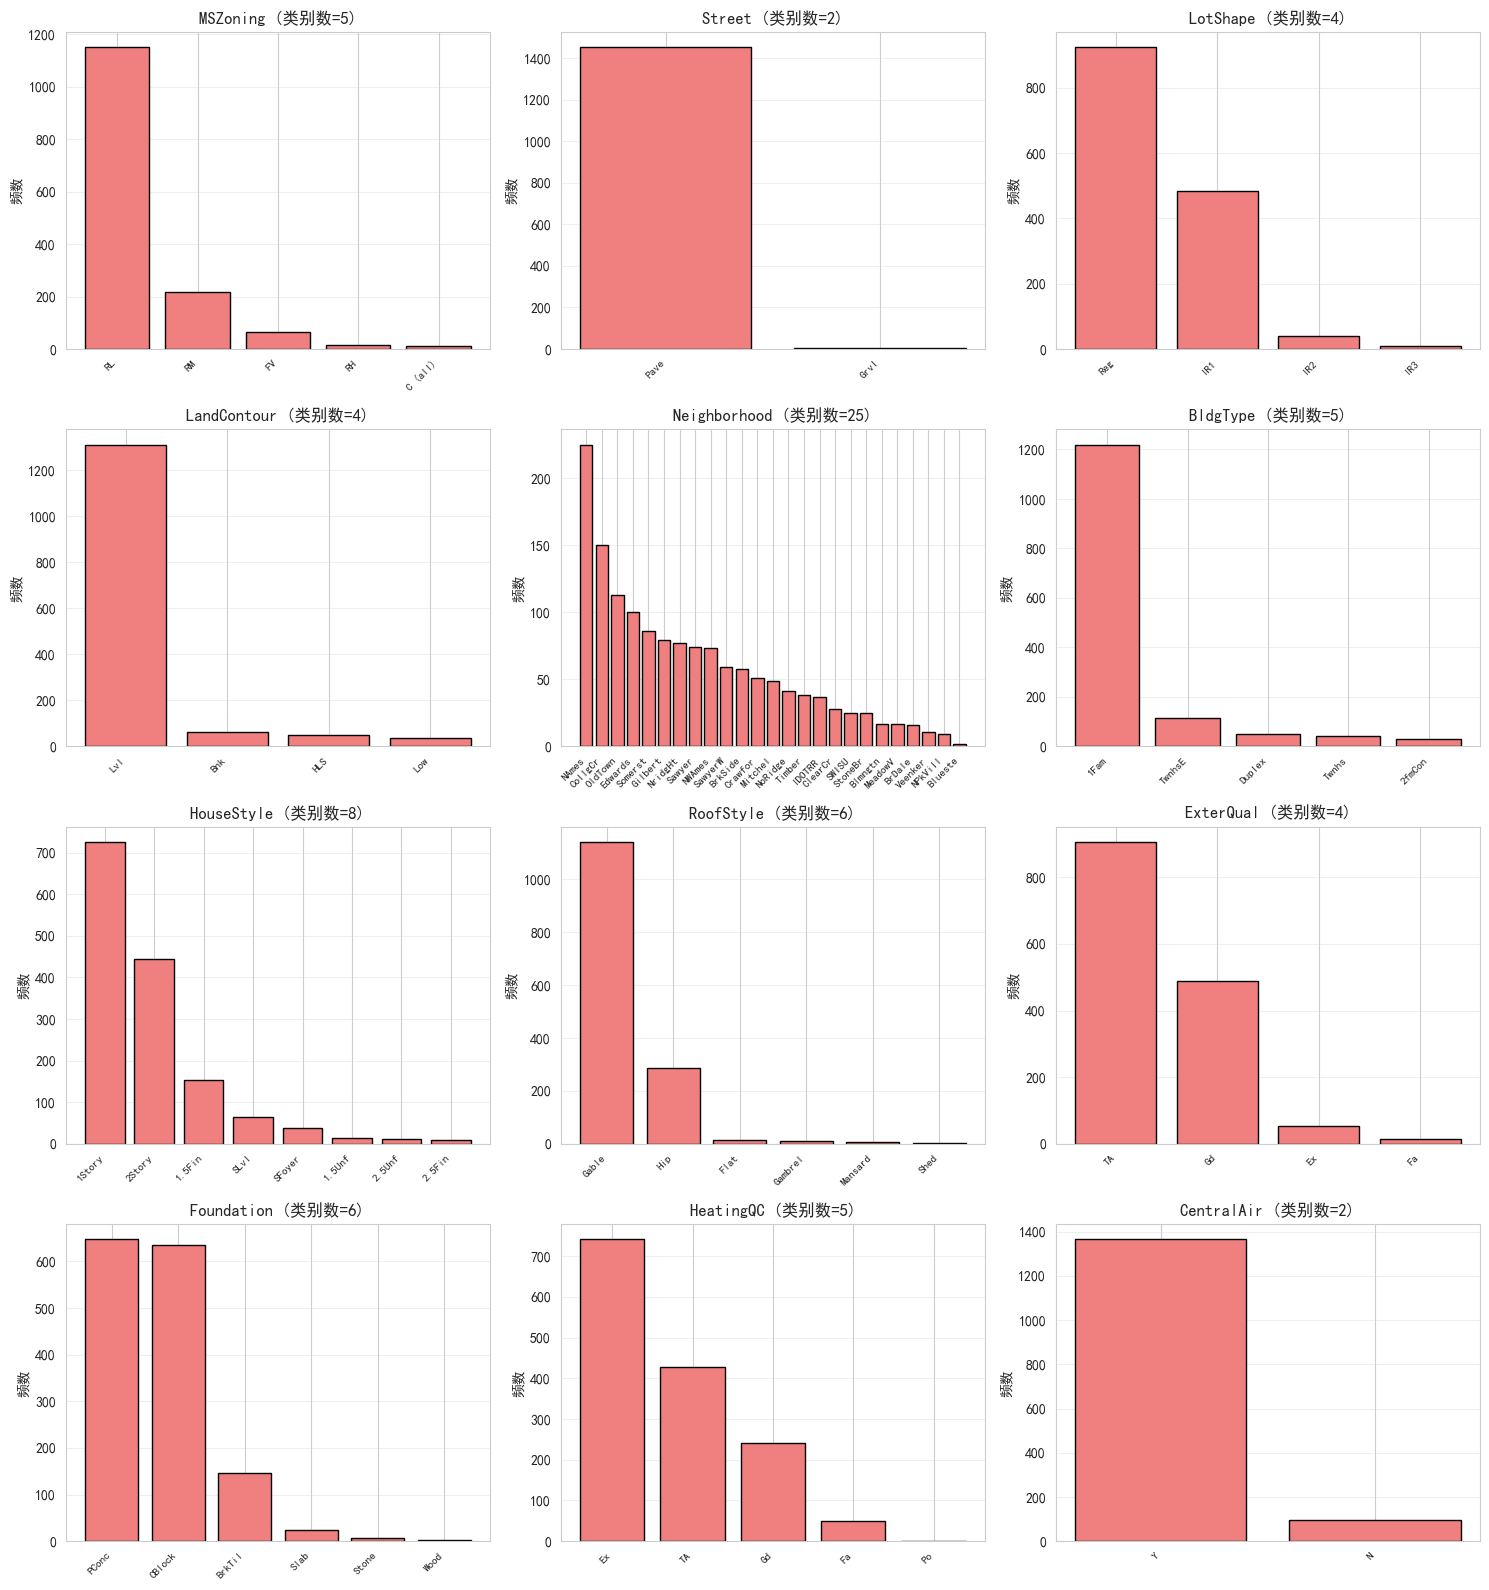


类别特征分析结论:
1. Neighborhood特征类别较多，不同社区房价差异可能很大
2. 质量评级特征(ExterQual, HeatingQC等)以优良等级为主
3. 大部分房屋有中央空调(CentralAir=Y)


In [10]:
# 选择重要的类别特征
important_categorical = [
    'MSZoning', 'Street', 'LotShape', 'LandContour',
    'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle',
    'ExterQual', 'Foundation', 'HeatingQC', 'CentralAir'
]

# 确保特征存在
important_categorical = [f for f in important_categorical if f in train.columns]

# 可视化类别特征频次
n_features = len(important_categorical)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(important_categorical):
    ax = axes[idx]
    value_counts = train[feature].value_counts()
    
    ax.bar(range(len(value_counts)), value_counts.values, color='lightcoral', edgecolor='black')
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('频数')
    ax.set_title(f'{feature} (类别数={len(value_counts)})')
    ax.grid(True, alpha=0.3, axis='y')

# 隐藏多余的子图
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print('\n类别特征分析结论:')
print('1. Neighborhood特征类别较多，不同社区房价差异可能很大')
print('2. 质量评级特征(ExterQual, HeatingQC等)以优良等级为主')
print('3. 大部分房屋有中央空调(CentralAir=Y)')

### 3.5 特征相关性分析

分析与目标变量最相关的Top 20个数值特征，绘制相关性热力图。

与目标变量SalePrice相关性最高的前20个特征:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
Name: SalePrice, dtype: float64


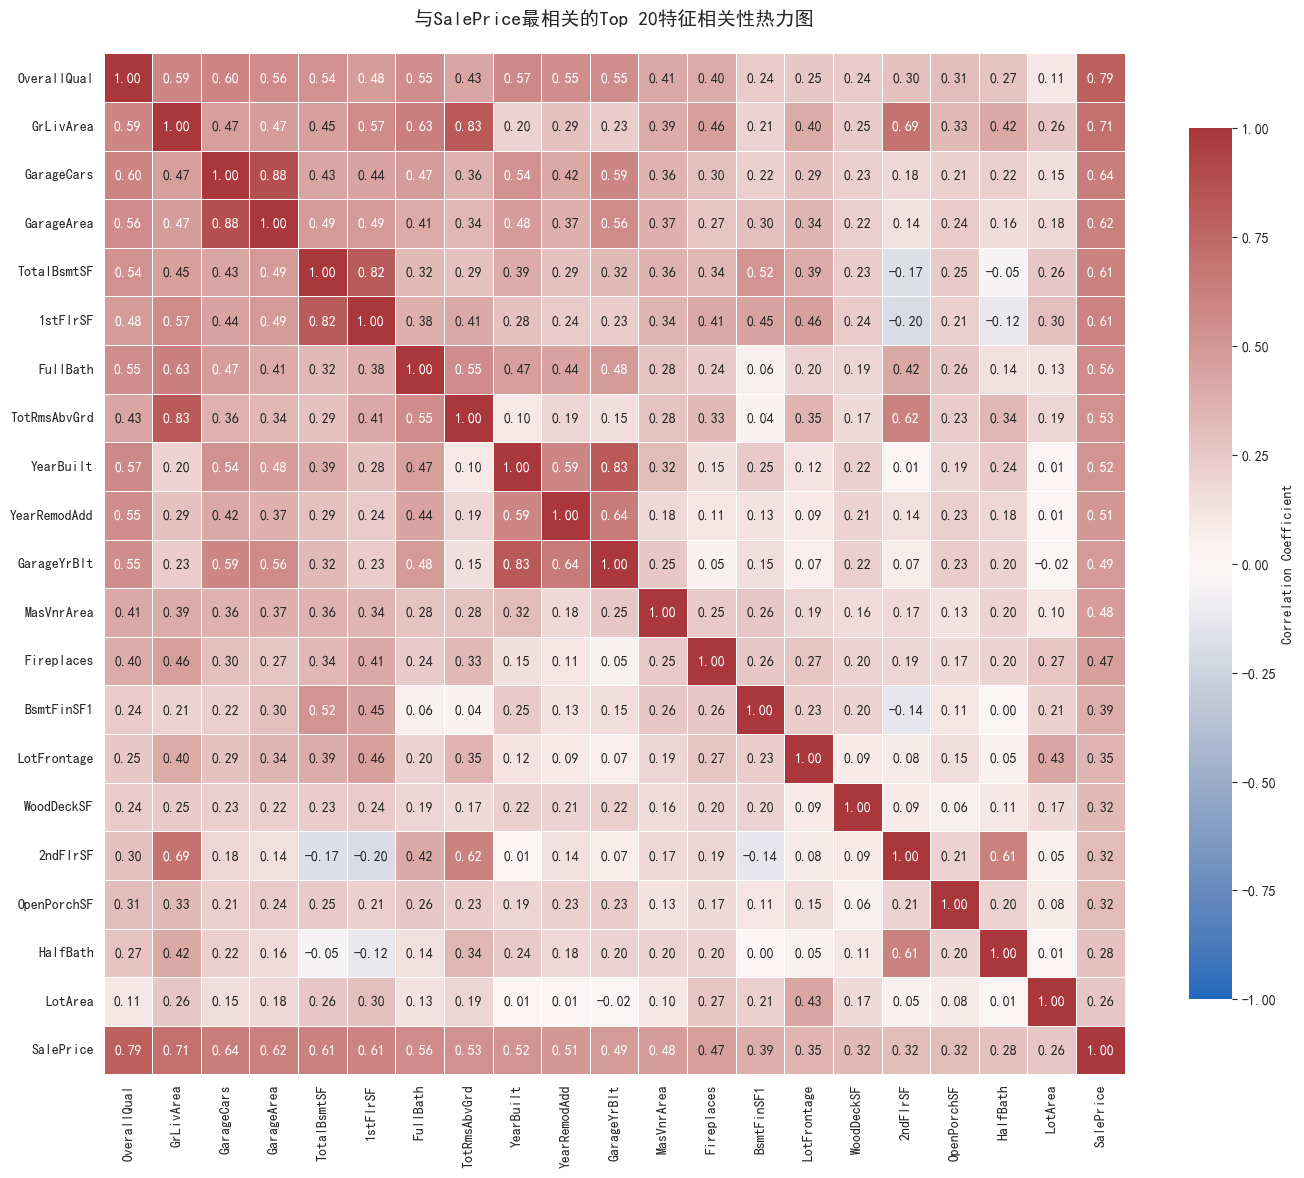


相关性分析结论:
1.  OverallQual(整体质量)与房价相关性最强(>0.79)
2. GrLivArea(地上居住面积)、GarageCars(车库容量)等也有很强相关性
3. 许多面积相关特征之间存在较强的正相关性


In [11]:
# 计算与目标变量的相关性
numeric_features_all = train.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in numeric_features_all:
    numeric_features_all.remove(TARGET)
if 'Id' in numeric_features_all:
    numeric_features_all.remove('Id')

# 计算相关系数
correlations = train[numeric_features_all + [TARGET]].corr()[TARGET].sort_values(ascending=False)

print('与目标变量SalePrice相关性最高的前20个特征:')
print(correlations[1:21])  # 排除自身

# 选择Top 20特征绘制相关性矩阵
top_features = correlations[1:21].index.tolist()
corr_matrix = train[top_features + [TARGET]].corr()

# 创建自定义颜色映射：负相关为蓝色，0为白色，正相关为红色
from matplotlib.colors import LinearSegmentedColormap

# 方案1：使用seaborn内置的vlag调色板（推荐）
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='vlag',  # 或者使用 'coolwarm', 'RdBu_r', 'seismic'
            center=0,     # 0值居中为白色
            vmin=-1,      # 设置最小值
            vmax=1,       # 设置最大值
            square=True, 
            linewidths=0.5, 
            cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'})
plt.title('与SalePrice最相关的Top 20特征相关性热力图', fontsize=14, pad=20)
plt. tight_layout()
plt.show()

print('\n相关性分析结论:')
print('1.  OverallQual(整体质量)与房价相关性最强(>0.79)')
print('2. GrLivArea(地上居住面积)、GarageCars(车库容量)等也有很强相关性')
print('3. 许多面积相关特征之间存在较强的正相关性')

### 3.6 异常值检测

使用箱线图检测重要数值特征中的异常值。

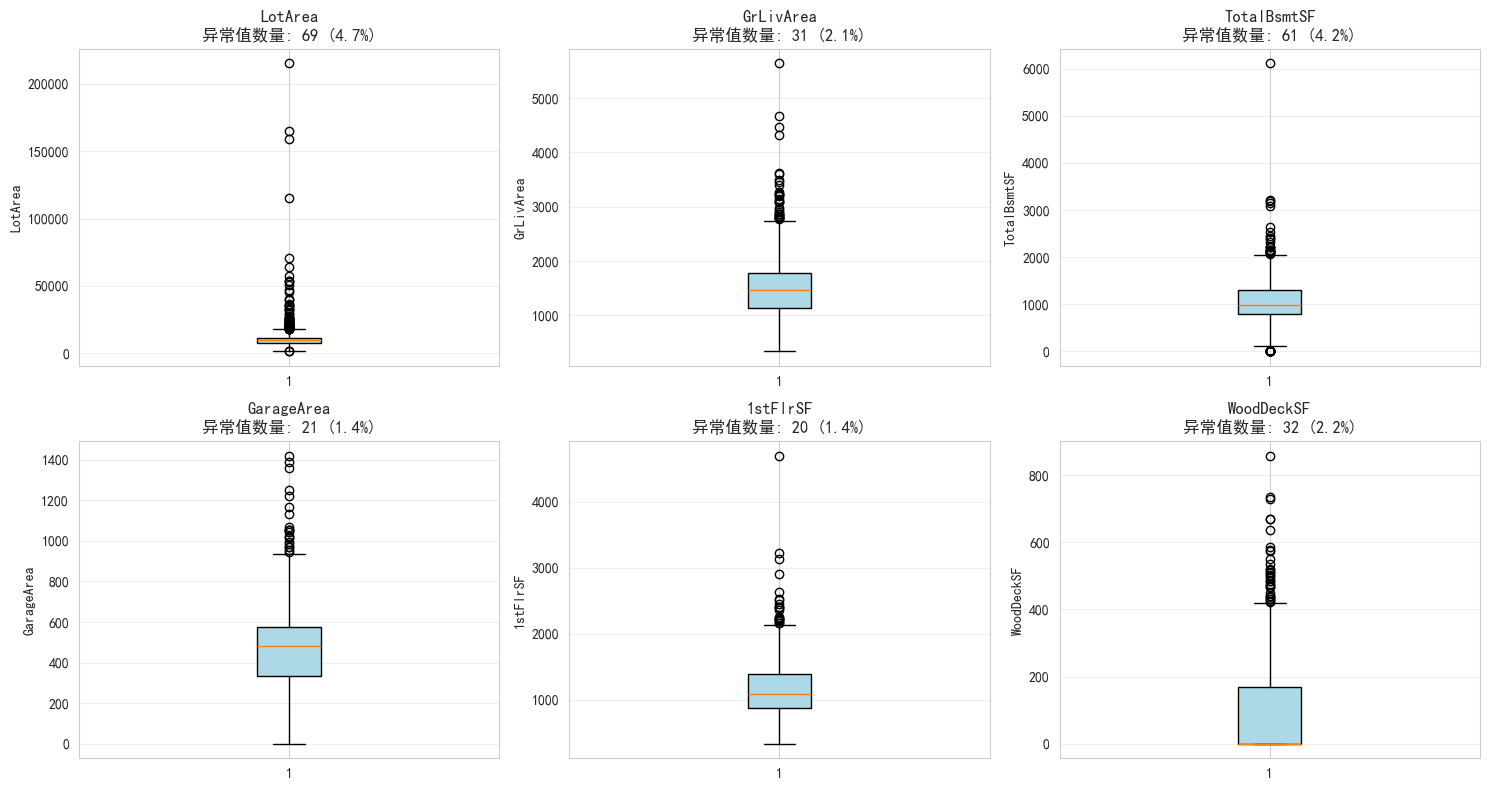


异常值分析结论:
1. LotArea和GrLivArea存在较多异常值，主要是极大面积的房产
2. 这些异常值可能是真实的高端房产，需要谨慎处理
3. 后续可以考虑使用log变换或设置上限来处理


In [12]:
# 异常值检测可视化
outlier_features = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'WoodDeckSF']
outlier_features = [f for f in outlier_features if f in train.columns]

n_features = len(outlier_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(outlier_features):
    ax = axes[idx]
    data = train[feature].dropna()
    
    # 绘制箱线图
    bp = ax.boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_edgecolor('black')
    
    # 计算异常值
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    ax.set_ylabel(feature)
    ax.set_title(f'{feature}\n异常值数量: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)')
    ax.grid(True, alpha=0.3, axis='y')

# 隐藏多余的子图
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print('\n异常值分析结论:')
print('1. LotArea和GrLivArea存在较多异常值，主要是极大面积的房产')
print('2. 这些异常值可能是真实的高端房产，需要谨慎处理')
print('3. 后续可以考虑使用log变换或设置上限来处理')

### 3.7 特征与目标变量关系分析

通过散点图和箱线图分析关键特征与房价的关系。

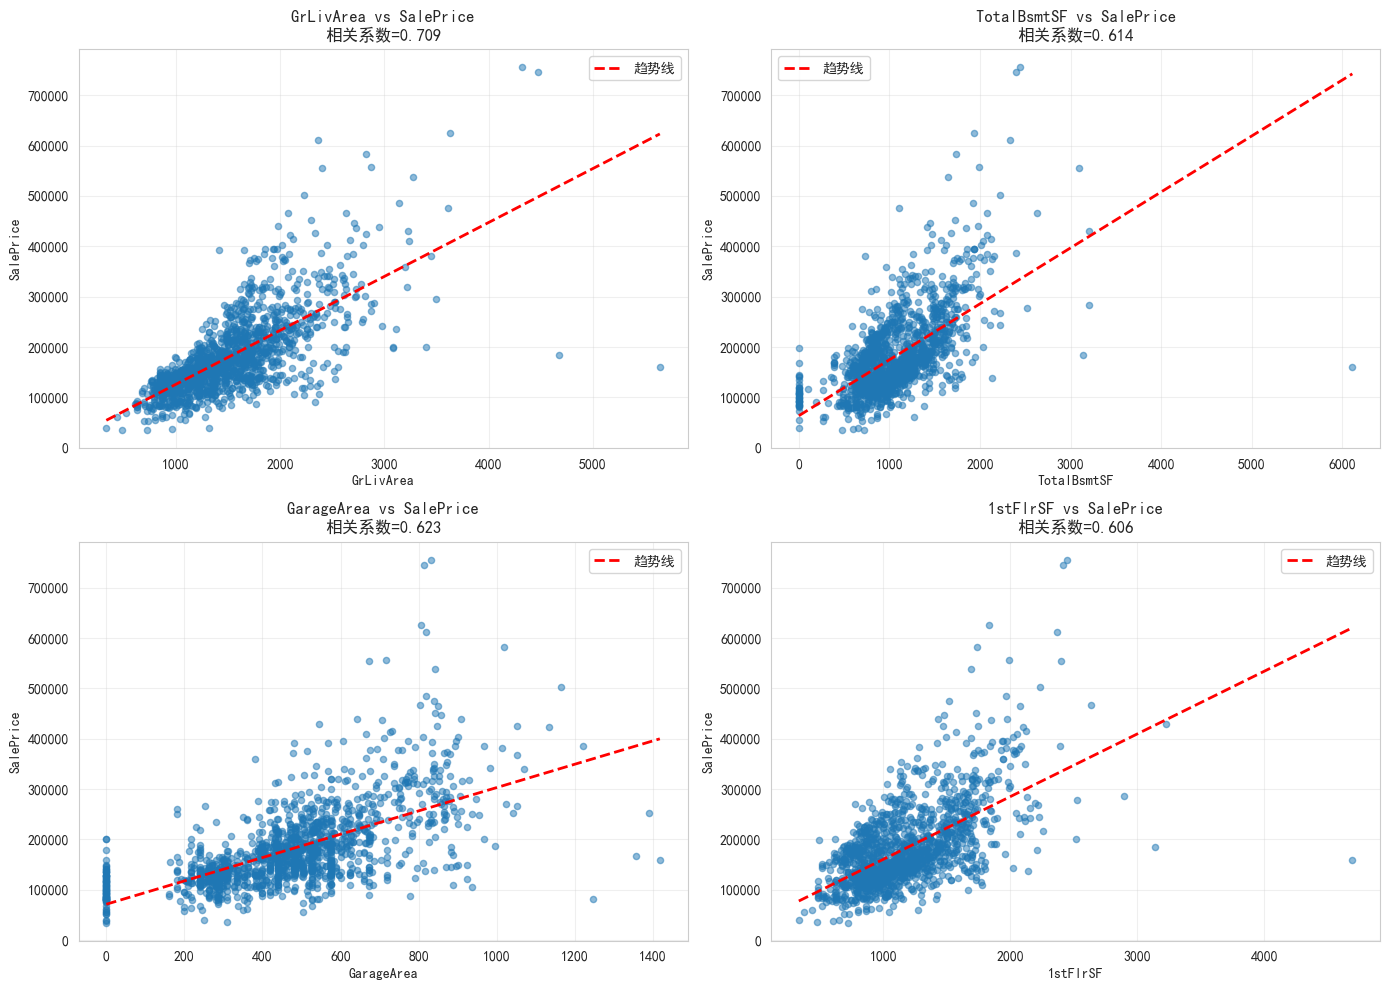


特征-目标关系分析结论:
1. 面积特征与房价呈现明显的正相关关系
2. 存在一些偏离趋势线的点，可能是异常值或特殊房产
3. 相关性越强的特征，散点越贴近趋势线


In [13]:
# 数值特征与目标变量的散点图
scatter_features = ['GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF']
scatter_features = [f for f in scatter_features if f in train.columns]

n_features = len(scatter_features)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(scatter_features):
    if idx < len(axes):
        ax = axes[idx]
        ax.scatter(train[feature], y, alpha=0.5, s=20)
        
        # 添加趋势线
        z = np.polyfit(train[feature].dropna(), y[train[feature].notna()], 1)
        p = np.poly1d(z)
        ax.plot(train[feature].sort_values(), p(train[feature].sort_values()), 
                'r--', linewidth=2, label='趋势线')
        
        ax.set_xlabel(feature)
        ax.set_ylabel(TARGET)
        corr = train[[feature, TARGET]].corr().iloc[0, 1]
        ax.set_title(f'{feature} vs {TARGET}\n相关系数={corr:.3f}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n特征-目标关系分析结论:')
print('1. 面积特征与房价呈现明显的正相关关系')
print('2. 存在一些偏离趋势线的点，可能是异常值或特殊房产')
print('3. 相关性越强的特征，散点越贴近趋势线')

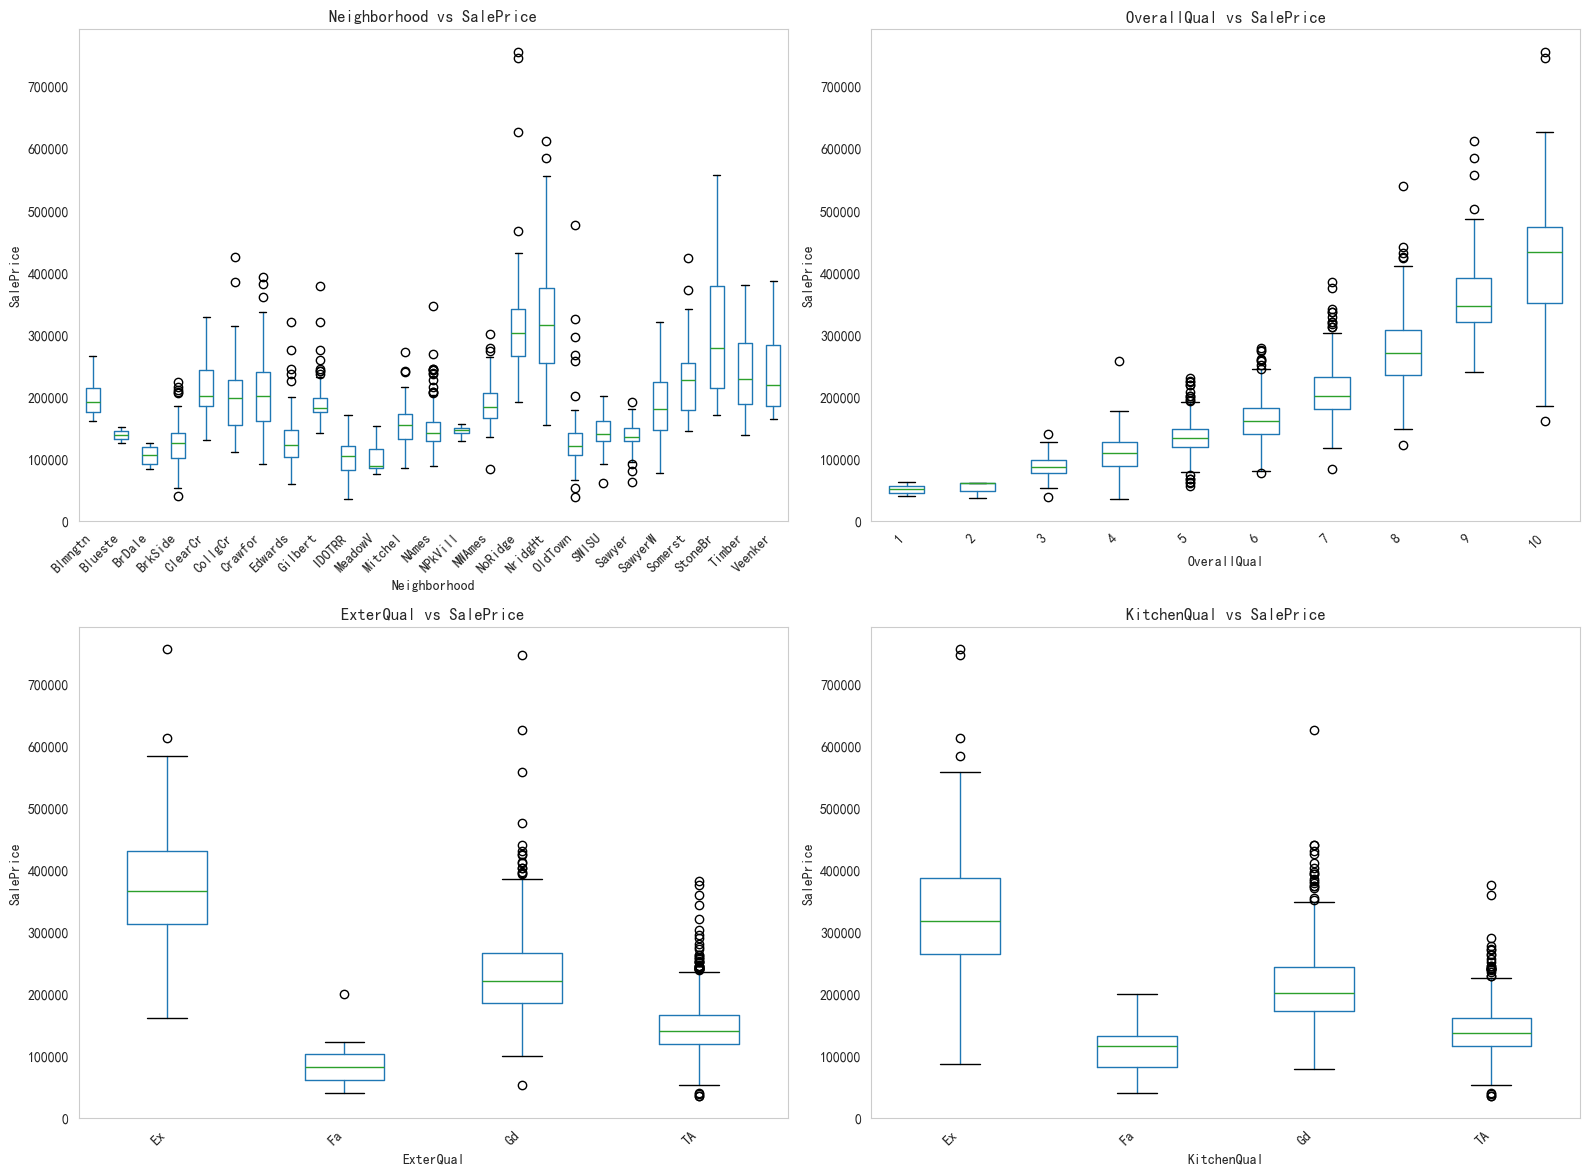


类别特征-目标关系分析结论:
1. 质量等级越高，房价明显越高，呈现阶梯状分布
2. 不同Neighborhood(社区)的房价差异很大，是重要的预测特征
3. 质量特征的区分度很强，适合作为预测特征


In [14]:
# 类别特征与目标变量的箱线图
cat_features = ['Neighborhood', 'OverallQual', 'ExterQual', 'KitchenQual']
cat_features = [f for f in cat_features if f in train.columns]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(cat_features):
    if idx < len(axes):
        ax = axes[idx]
        
        # 计算每个类别的中位数并排序
        order = train.groupby(feature)[TARGET].median().sort_values().index
        
        # 绘制箱线图
        train.boxplot(column=TARGET, by=feature, ax=ax, grid=False)
        ax.set_xlabel(feature)
        ax.set_ylabel(TARGET)
        ax.set_title(f'{feature} vs {TARGET}')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
plt.suptitle('')  # 移除默认标题
plt.tight_layout()
plt.show()

print('\n类别特征-目标关系分析结论:')
print('1. 质量等级越高，房价明显越高，呈现阶梯状分布')
print('2. 不同Neighborhood(社区)的房价差异很大，是重要的预测特征')
print('3. 质量特征的区分度很强，适合作为预测特征')

## 4. 数据预处理与特征工程

基于EDA发现的问题，进行数据预处理和特征工程优化。

### 4.1 合并训练集和测试集

为了保持一致的数据处理，我们将训练集和测试集合并后统一处理。

In [15]:
# 合并训练集和测试集（不包含目标变量）
full = pd.concat([train.drop(columns=[TARGET]), test], axis=0, ignore_index=True)
print(f'合并后数据集形状: {full.shape}')
print(f'训练集样本数: {len(train)}')
print(f'测试集样本数: {len(test)}')

合并后数据集形状: (2919, 80)
训练集样本数: 1460
测试集样本数: 1459


### 4.2 优化的缺失值处理策略

根据特征的语义和缺失值的含义，采用不同的填充策略：
1. **质量/条件类特征**：缺失通常表示"无该设施"，填充为'None'
2. **面积类特征**：缺失表示该部分不存在，填充为0
3. **年份类特征**：使用合理的默认值或众数
4. **其他特征**：使用众数或中位数填充

In [16]:
# 优化的缺失值处理

# 1. 将部分数值特征转为类别特征
numerical_as_categorical = ['MSSubClass', 'OverallQual', 'OverallCond']
for col in numerical_as_categorical:
    if col in full.columns:
        full[col] = full[col].astype(str)

# 2. 质量/条件类特征，缺失表示"无"
quality_features = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]
for col in quality_features:
    if col in full.columns:
        full[col] = full[col].fillna('None')

# 3. 面积类特征，缺失表示0
area_features = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
    'MasVnrArea'
]
for col in area_features:
    if col in full.columns:
        full[col] = full[col].fillna(0)

# 4. 年份特征，使用0表示无
year_features = ['GarageYrBlt']
for col in year_features:
    if col in full.columns:
        full[col] = full[col].fillna(0)

# 5. LotFrontage使用社区中位数填充
if 'LotFrontage' in full.columns and 'Neighborhood' in full.columns:
    full['LotFrontage'] = full.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median())
    )

# 6. 其他类别特征使用众数填充
categorical_cols = full.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if full[col].isnull().sum() > 0:
        full[col] = full[col].fillna(full[col].mode()[0])

# 7. 其他数值特征使用中位数填充
numeric_cols = full.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if full[col].isnull().sum() > 0:
        full[col] = full[col].fillna(full[col].median())

print(f'处理后剩余缺失值数量: {full.isnull().sum().sum()}')
print('缺失值处理完成！')

处理后剩余缺失值数量: 0
缺失值处理完成！


### 4.3 增强的特征工程

创建更多有意义的衍生特征和特征交互，以提升模型性能。

In [17]:
# 增强的特征工程
def add_optimized_features(df):
    """添加优化的衍生特征"""
    df = df.copy()
    
    # 1. 总面积特征
    if all(c in df.columns for c in ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']):
        df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    # 2. 总浴室数量
    if all(c in df.columns for c in ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']):
        df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    
    # 3. 总门廊面积
    if all(c in df.columns for c in ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']):
        df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    
    # 4. 房屋年龄（相对于售出年份）
    if all(c in df.columns for c in ['YearBuilt', 'YrSold']):
        df['HouseAge'] = df['YrSold'] - df['YearBuilt']
        df['HouseAge'] = df['HouseAge'].apply(lambda x: max(0, x))
    
    # 5. 改造年龄
    if all(c in df.columns for c in ['YearRemodAdd', 'YrSold']):
        df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
        df['RemodAge'] = df['RemodAge'].apply(lambda x: max(0, x))
    
    # 6. 是否改造过
    if all(c in df.columns for c in ['YearBuilt', 'YearRemodAdd']):
        df['IsRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
    
    # 7. 是否新房（售出年份=建造年份）
    if all(c in df.columns for c in ['YearBuilt', 'YrSold']):
        df['IsNewHouse'] = (df['YrSold'] == df['YearBuilt']).astype(int)
    
    # 8. 有无地下室
    if 'TotalBsmtSF' in df.columns:
        df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    
    # 9. 有无车库
    if 'GarageArea' in df.columns:
        df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    
    # 10. 有无二楼
    if '2ndFlrSF' in df.columns:
        df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    
    # 11. 有无壁炉
    if 'Fireplaces' in df.columns:
        df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    
    # 12. 有无泳池
    if 'PoolArea' in df.columns:
        df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    
    # 13. 质量×条件 交互特征
    if 'OverallQual' in df.columns and 'OverallCond' in df.columns:
        df['QualCondProduct'] = df['OverallQual'].astype(float) * df['OverallCond'].astype(float)
    
    # 14. 居住面积 ÷ 地块面积（土地利用率）
    if all(c in df.columns for c in ['GrLivArea', 'LotArea']):
        df['LivingAreaRatio'] = df['GrLivArea'] / (df['LotArea'] + 1)
    
    # 15. 车库面积 ÷ 总面积
    if 'GarageArea' in df.columns and 'TotalSF' in df.columns:
        df['GarageAreaRatio'] = df['GarageArea'] / (df['TotalSF'] + 1)
    
    return df

# 应用特征工程
full = add_optimized_features(full)

print(f'特征工程后数据形状: {full.shape}')
print(f'新增特征数量: {full.shape[1] - (train.shape[1] - 1 + test.shape[1] - train.shape[1])}')
print('\n新增特征列表:')
new_features = [col for col in full.columns if col not in train.columns and col not in test.columns]
for i, feat in enumerate(new_features, 1):
    print(f'{i}. {feat}')

特征工程后数据形状: (2919, 95)
新增特征数量: 16

新增特征列表:
1. TotalSF
2. TotalBath
3. TotalPorchSF
4. HouseAge
5. RemodAge
6. IsRemodeled
7. IsNewHouse
8. HasBasement
9. HasGarage
10. Has2ndFloor
11. HasFireplace
12. HasPool
13. QualCondProduct
14. LivingAreaRatio
15. GarageAreaRatio


### 4.4 异常值处理

对识别出的极端异常值进行处理，使用log变换缓解长尾分布。

In [18]:
# 移除Id列（如果存在）
if 'Id' in full.columns:
    full = full.drop(columns=['Id'])

# 对数值特征进行偏度校正
numeric_cols = full.select_dtypes(include=[np.number]).columns.tolist()

# 计算偏度
skewness = full[numeric_cols].skew().sort_values(ascending=False)
high_skew = skewness[abs(skewness) > 0.75]

print(f'偏度大于0.75的特征数量: {len(high_skew)}')
print('\n偏度最高的10个特征:')
print(high_skew.head(10))

# 对高偏度且非负的特征进行log1p变换
for col in high_skew.index:
    if col in full.columns:
        # 确保所有值非负
        if (full[col] >= 0).all():
            full[col] = np.log1p(full[col])

print(f'\n对{len(high_skew)}个高偏度特征进行了log1p变换')

偏度大于0.75的特征数量: 29

偏度最高的10个特征:
MiscVal          21.958480
PoolArea         16.907017
HasPool          14.891972
LotArea          12.829025
LowQualFinSF     12.094977
3SsnPorch        11.381914
IsNewHouse        4.714660
KitchenAbvGr      4.304467
BsmtFinSF2        4.148275
EnclosedPorch     4.005950
dtype: float64

对29个高偏度特征进行了log1p变换


### 4.5 特征编码

使用One-Hot编码处理类别特征。

In [19]:
# One-Hot编码
categorical_cols = full.select_dtypes(include=['object']).columns.tolist()
numeric_cols = full.select_dtypes(include=[np.number]).columns.tolist()

print(f'类别特征数量: {len(categorical_cols)}')
print(f'数值特征数量: {len(numeric_cols)}')

# 对类别特征进行One-Hot编码
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    encoded_cats = encoder.fit_transform(full[categorical_cols])
    
    # 获取编码后的特征名
    cat_feature_names = encoder.get_feature_names_out(categorical_cols)
    encoded_cats_df = pd.DataFrame(encoded_cats, columns=cat_feature_names, index=full.index)
    
    # 合并数值特征和编码后的类别特征
    full_encoded = pd.concat([full[numeric_cols], encoded_cats_df], axis=1)
else:
    full_encoded = full[numeric_cols].copy()

print(f'\n编码后总特征数量: {full_encoded.shape[1]}')
print(f'  数值特征: {len(numeric_cols)}')
print(f'  编码后的类别特征: {full_encoded.shape[1] - len(numeric_cols)}')

类别特征数量: 46
数值特征数量: 48

编码后总特征数量: 303
  数值特征: 48
  编码后的类别特征: 255


### 4.6 拆分训练集和测试集

将处理后的数据重新拆分为训练集和测试集。

In [20]:
# 拆分训练集和测试集
X = full_encoded.iloc[:len(train), :].copy()
X_test = full_encoded.iloc[len(train):, :].copy()

# 确保数据类型一致
X = X.astype(float)
X_test = X_test.astype(float)

print(f'训练特征集形状: {X.shape}')
print(f'测试特征集形状: {X_test.shape}')
print(f'训练目标变量形状: {y_log.shape}')
print('\n数据预处理完成，准备建模！')

训练特征集形状: (1460, 303)
测试特征集形状: (1459, 303)
训练目标变量形状: (1460,)

数据预处理完成，准备建模！


## 5. 模型训练与评估

使用K折交叉验证训练多个模型，并评估其性能。

### 5.1 定义训练和评估函数

In [21]:
# 定义评估指标
def rmse_log_metric(y_true_log, y_pred_log):
    """计算log空间的RMSE"""
    return np.sqrt(mean_squared_error(y_true_log, y_pred_log))

# K折训练函数
def kfold_train(model_name, model, X, y, n_splits=10, random_state=RANDOM_STATE):
    """K折交叉验证训练"""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    models = []
    oof_predictions = np.zeros(len(X))
    fold_scores = []
    
    print(f'\n训练 {model_name} 模型（{n_splits}折交叉验证）...')
    print('='*60)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # 训练模型
        if model_name == 'XGBoost':
            fold_model = xgb.XGBRegressor(
                n_estimators=1000,
                learning_rate=0.05,
                max_depth=4,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=random_state,
                n_jobs=-1
            )
            fold_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        else:
            from sklearn.base import clone
            fold_model = clone(model)
            fold_model.fit(X_train, y_train)
        
        # 预测验证集
        val_pred = fold_model.predict(X_val)
        oof_predictions[val_idx] = val_pred
        
        # 计算得分
        fold_score = rmse_log_metric(y_val, val_pred)
        fold_scores.append(fold_score)
        
        models.append(fold_model)
        print(f'Fold {fold:2d} - RMSE: {fold_score:.5f}')
    
    # 计算整体OOF得分
    oof_score = rmse_log_metric(y, oof_predictions)
    
    print('='*60)
    print(f'{model_name} OOF RMSE: {oof_score:.5f}')
    print(f'平均 Fold RMSE: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}')
    
    return models, oof_predictions, oof_score

# OOF评估可视化函数
def plot_oof_evaluation(y_true, oof_dict):
    """可视化OOF预测效果"""
    n_models = len(oof_dict)
    fig, axes = plt.subplots(n_models, 2, figsize=(14, 5*n_models))
    
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (name, oof_pred) in enumerate(oof_dict.items()):
        # 散点图
        ax1 = axes[idx, 0]
        ax1.scatter(y_true, oof_pred, alpha=0.5, s=20)
        ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', lw=2, label='y=x')
        ax1.set_xlabel('真实值 (log)')
        ax1.set_ylabel('预测值 (log)')
        ax1.set_title(f'{name} - 预测vs真实 (R²={np.corrcoef(y_true, oof_pred)[0,1]**2:.4f})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 残差分布
        ax2 = axes[idx, 1]
        residuals = y_true - oof_pred
        ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
        ax2.axvline(0, color='red', linestyle='--', linewidth=2)
        ax2.set_xlabel('残差 (真实 - 预测)')
        ax2.set_ylabel('频数')
        ax2.set_title(f'{name} - 残差分布 (均值={residuals.mean():.5f}, 标准差={residuals.std():.5f})')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print('训练和评估函数定义完成！')

训练和评估函数定义完成！


### 5.2 训练Ridge回归模型

Ridge回归通过L2正则化防止过拟合，适合高维特征数据。


训练 Ridge 模型（10折交叉验证）...
Fold  1 - RMSE: 0.10844
Fold  2 - RMSE: 0.14979
Fold  3 - RMSE: 0.10695
Fold  4 - RMSE: 0.11943
Fold  5 - RMSE: 0.14279
Fold  6 - RMSE: 0.18521
Fold  7 - RMSE: 0.12785
Fold  8 - RMSE: 0.11136
Fold  9 - RMSE: 0.13140
Fold 10 - RMSE: 0.09095
Ridge OOF RMSE: 0.12995
平均 Fold RMSE: 0.12742 ± 0.02554


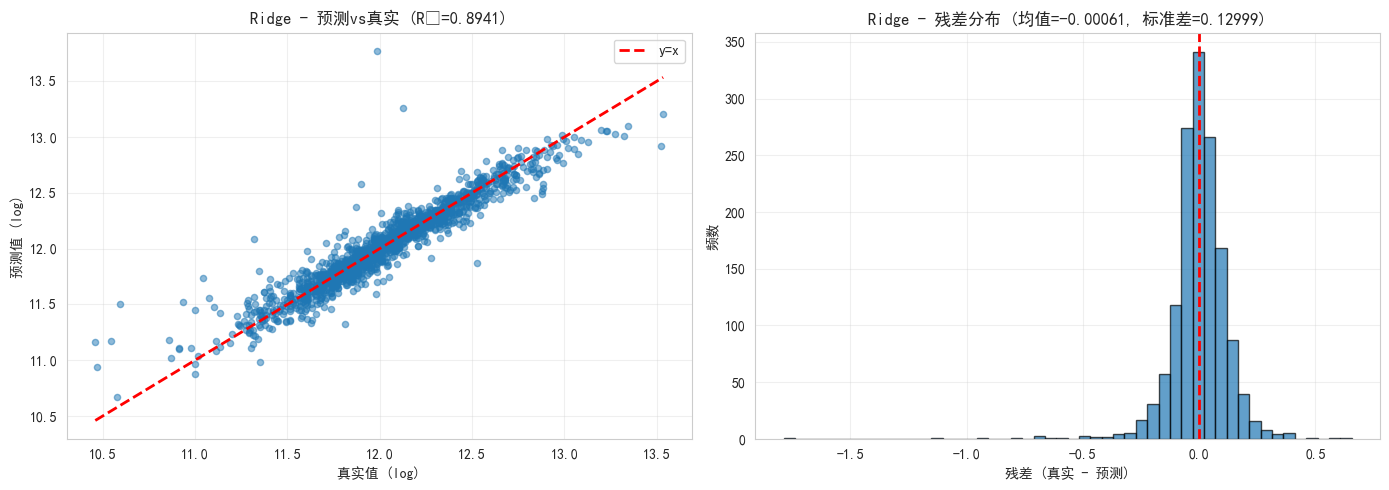

In [22]:
# 训练Ridge模型
ridge_model = Ridge(alpha=10.0, random_state=RANDOM_STATE)
ridge_models, ridge_oof, ridge_rmse = kfold_train('Ridge', ridge_model, X, y_log)

# 可视化OOF预测
plot_oof_evaluation(y_log, {'Ridge': ridge_oof})

### 5.3 训练随机森林模型

随机森林能够捕捉非线性关系和特征交互。


训练 RandomForest 模型（10折交叉验证）...
Fold  1 - RMSE: 0.14981
Fold  2 - RMSE: 0.16400
Fold  3 - RMSE: 0.10830
Fold  4 - RMSE: 0.14746
Fold  5 - RMSE: 0.14914
Fold  6 - RMSE: 0.14615
Fold  7 - RMSE: 0.17362
Fold  8 - RMSE: 0.13113
Fold  9 - RMSE: 0.13629
Fold 10 - RMSE: 0.10264
RandomForest OOF RMSE: 0.14243
平均 Fold RMSE: 0.14085 ± 0.02113


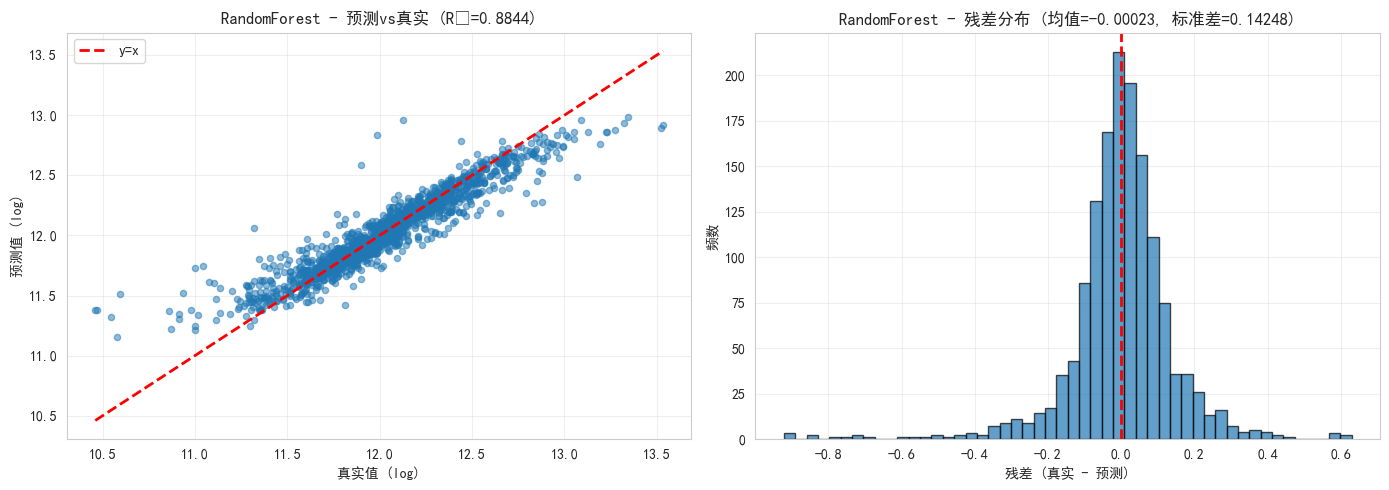

In [23]:
# 训练RandomForest模型
rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=15,
    min_samples_leaf=2,
    min_samples_split=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_models, rf_oof, rf_rmse = kfold_train('RandomForest', rf_model, X, y_log)

# 可视化OOF预测
plot_oof_evaluation(y_log, {'RandomForest': rf_oof})

### 5.4 训练XGBoost模型

XGBoost是梯度提升树的高效实现，通常能获得最佳性能。


训练 XGBoost 模型（10折交叉验证）...
Fold  1 - RMSE: 0.11795
Fold  2 - RMSE: 0.15194
Fold  3 - RMSE: 0.10425
Fold  4 - RMSE: 0.12527
Fold  5 - RMSE: 0.15142
Fold  6 - RMSE: 0.14353
Fold  7 - RMSE: 0.14022
Fold  8 - RMSE: 0.10937
Fold  9 - RMSE: 0.12435
Fold 10 - RMSE: 0.08690
XGBoost OOF RMSE: 0.12717
平均 Fold RMSE: 0.12552 ± 0.02043


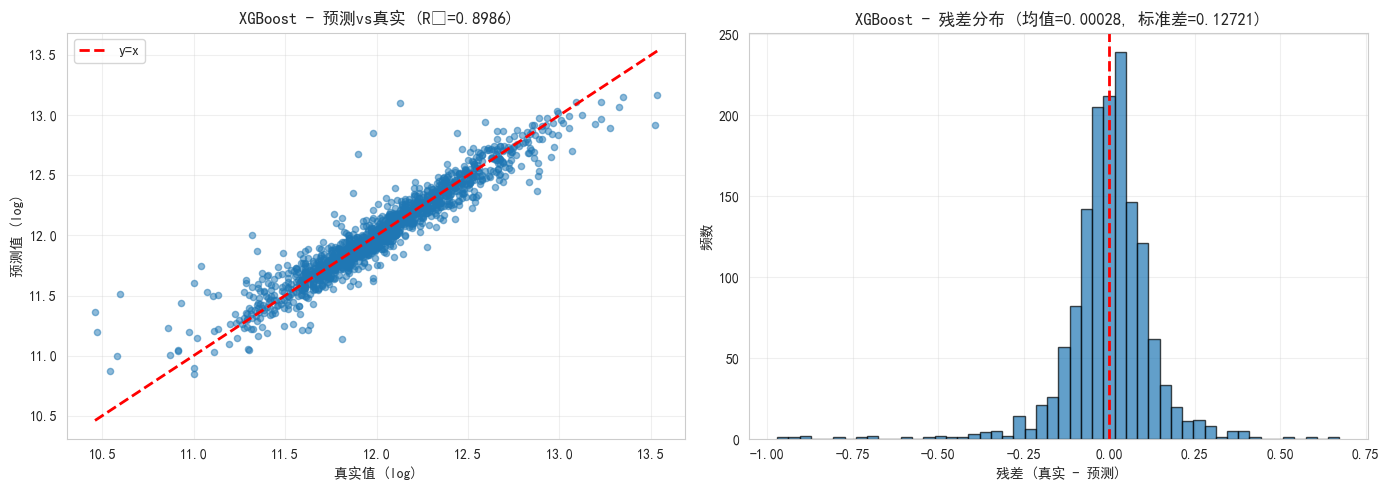

In [24]:
# 训练XGBoost模型
xgb_models, xgb_oof, xgb_rmse = kfold_train('XGBoost', None, X, y_log)

# 可视化OOF预测
plot_oof_evaluation(y_log, {'XGBoost': xgb_oof})

### 5.5 模型性能对比

比较三个基模型的OOF性能。

模型间相关系数矩阵:


,Ridge,RandomForest,XGBoost,y_true_log
Ridge,1.000000,0.973064,0.980072,0.945591
RandomForest,0.973064,1.000000,0.980063,0.940433
XGBoost,0.980072,0.980063,1.000000,0.947936
y_true_log,0.945591,0.940433,0.947936,1.000000


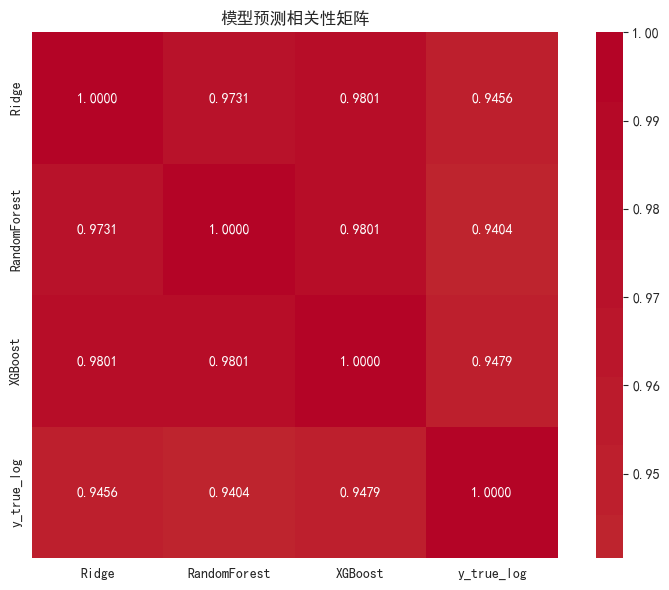


模型性能对比:
Ridge        OOF RMSE: 0.12995
RandomForest OOF RMSE: 0.14243
XGBoost      OOF RMSE: 0.12717


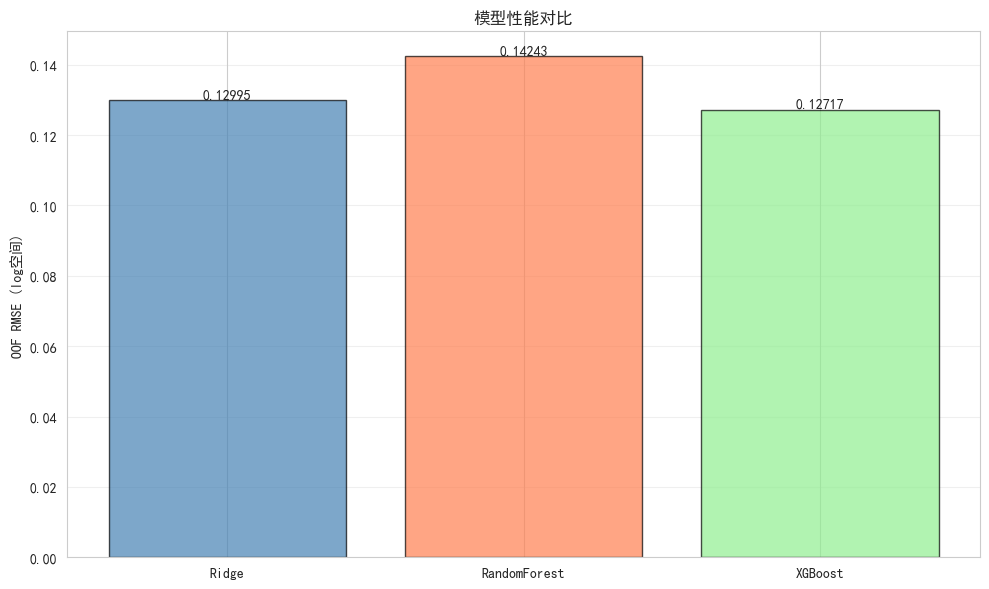

In [25]:
# 汇总所有模型的OOF预测
oof_df = pd.DataFrame({
    'Ridge': ridge_oof,
    'RandomForest': rf_oof,
    'XGBoost': xgb_oof,
    'y_true_log': y_log.values
})

# 计算相关系数矩阵
print('模型间相关系数矩阵:')
corr_matrix = oof_df.corr()
display(corr_matrix)

# 可视化相关系数
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='coolwarm', center=0, square=True)
plt.title('模型预测相关性矩阵')
plt.tight_layout()
plt.show()

# 性能对比
print('\n模型性能对比:')
print('='*50)
print(f'Ridge        OOF RMSE: {ridge_rmse:.5f}')
print(f'RandomForest OOF RMSE: {rf_rmse:.5f}')
print(f'XGBoost      OOF RMSE: {xgb_rmse:.5f}')
print('='*50)

# 绘制性能对比图
fig, ax = plt.subplots(figsize=(10, 6))
models = ['Ridge', 'RandomForest', 'XGBoost']
scores = [ridge_rmse, rf_rmse, xgb_rmse]
colors = ['steelblue', 'coral', 'lightgreen']

bars = ax.bar(models, scores, color=colors, edgecolor='black', alpha=0.7)
ax.set_ylabel('OOF RMSE (log空间)')
ax.set_title('模型性能对比')
ax.grid(True, alpha=0.3, axis='y')

# 在柱状图上标注数值
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.5f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [26]:
print("=== 模型训练结果 ===")
print(f"Ridge RMSE: {ridge_rmse:.6f}")
print(f"RandomForest RMSE: {rf_rmse:.6f}")
print(f"XGBoost RMSE: {xgb_rmse:.6f}")

print("\n=== 模型参数 ===")
print("Ridge:", ridge_model.get_params())
print("\nRandomForest:", rf_model.get_params())
print("\nXGBoost:", xgb_models[0].get_params())

=== 模型训练结果 ===
Ridge RMSE: 0.129952
RandomForest RMSE: 0.142431
XGBoost RMSE: 0.127170

=== 模型参数 ===
Ridge: {'alpha': 10.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001}

RandomForest: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

XGBoost: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': No


新衍生特征进入 Top 20 的数量: 6

进入 Top 20 的新特征:
['TotalSF', 'HouseAge', 'HasFireplace', 'QualCondProduct', 'TotalBath', 'IsNewHouse']


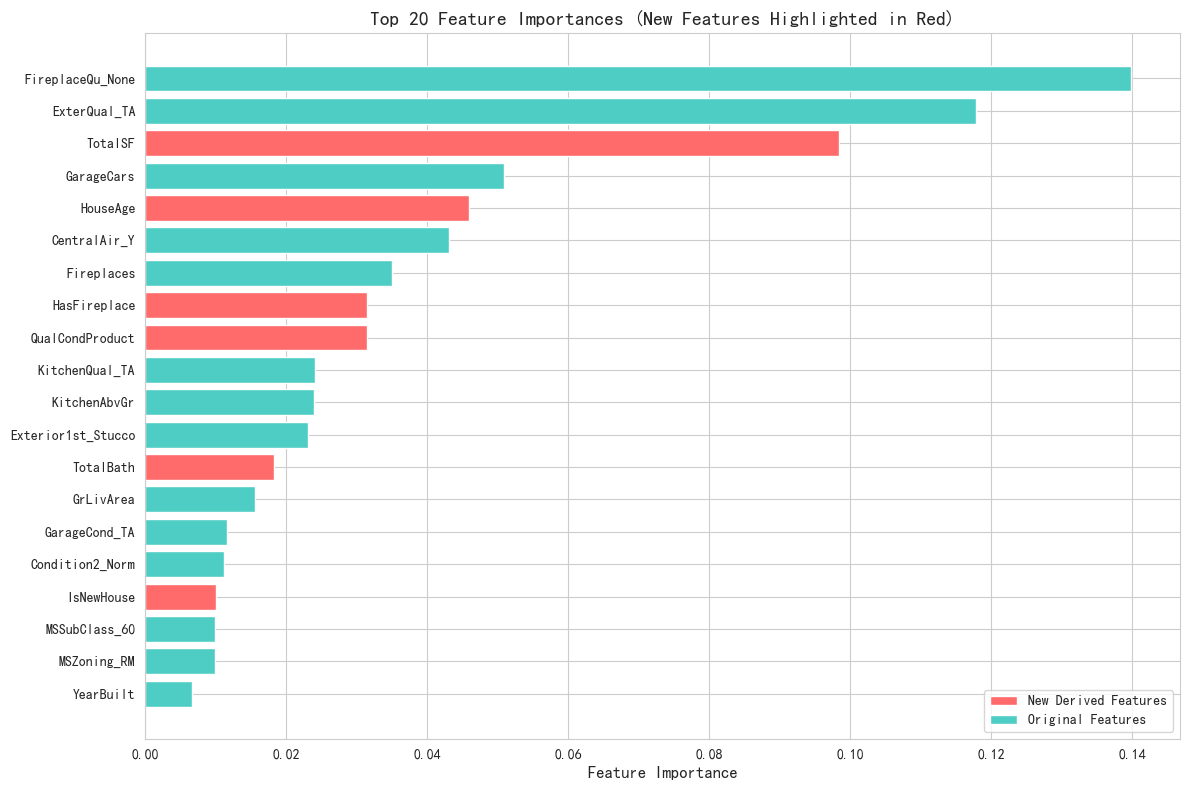


=== Top 20 Feature Importance ===
   FireplaceQu_None               0.139768
   ExterQual_TA                   0.117764
🆕 TotalSF                        0.098388
   GarageCars                     0.050906
🆕 HouseAge                       0.045899
   CentralAir_Y                   0.043108
   Fireplaces                     0.035032
🆕 HasFireplace                   0.031509
🆕 QualCondProduct                0.031404
   KitchenQual_TA                 0.024055
   KitchenAbvGr                   0.023968
   Exterior1st_Stucco             0.023125
🆕 TotalBath                      0.018194
   GrLivArea                      0.015590
   GarageCond_TA                  0.011642
   Condition2_Norm                0.011231
🆕 IsNewHouse                     0.010014
   MSSubClass_60                  0.009917
   MSZoning_RM                    0.009905
   YearBuilt                      0.006606


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 定义新衍生的特征列表
new_features = [
    'TotalSF', 'TotalBath', 'TotalPorchSF', 
    'HouseAge', 'RemodAge', 'IsRemodeled', 'IsNewHouse',
    'HasBasement', 'HasGarage', 'Has2ndFloor', 'HasFireplace', 'HasPool',
    'QualCondProduct', 'LivingAreaRatio', 'GarageAreaRatio'
]

# 判断模型类型
if isinstance(xgb_models, list):
    # 如果是交叉验证的多个模型，取第一个
    model_to_use = xgb_models[0]
elif 'xgb_model' in dir():
    model_to_use = xgb_model
else:
    print("找不到训练好的XGBoost模型")

# 获取特征重要性
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model_to_use.feature_importances_
}).sort_values('importance', ascending=False). head(20)

# 标记是否为新特征
importance_df['is_new'] = importance_df['feature'].isin(new_features)

# 统计新特征进入 Top 20 的数量
new_in_top20 = importance_df['is_new'].sum()
print(f'\n新衍生特征进入 Top 20 的数量: {new_in_top20}')
print(f'\n进入 Top 20 的新特征:')
new_feat_list = importance_df[importance_df['is_new']]['feature'].tolist()
print(new_feat_list)

# 可视化 - 新特征用不同颜色标注
plt.figure(figsize=(12, 8))
colors = ['#FF6B6B' if is_new else '#4ECDC4' for is_new in importance_df['is_new']]
bars = plt.barh(range(len(importance_df)), importance_df['importance'], color=colors)

plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt. title('Top 20 Feature Importances (New Features Highlighted in Red)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# 添加图例
legend_elements = [
    Patch(facecolor='#FF6B6B', label='New Derived Features'),
    Patch(facecolor='#4ECDC4', label='Original Features')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('feature_importance_top20.png', dpi=300, bbox_inches='tight')
plt. show()

# 输出详细的 Top 20 特征列表
print('\n=== Top 20 Feature Importance ===')
for idx, row in importance_df.iterrows():
    marker = '🆕' if row['is_new'] else '  '
    print(f'{marker} {row["feature"]:30s} {row["importance"]:.6f}')

## 6. 模型集成优化

通过加权平均的方式集成多个模型，以获得更好的泛化性能。

### 6.1 搜索最优集成权重

在网格空间中搜索使OOF RMSE最小的权重组合。

In [28]:
# 搜索最佳集成权重
def search_best_weights(oof_df, step=0.01):
    """搜索最优加权组合"""
    best_rmse = 1e9
    best_w = (0, 0, 0)
    preds_best = None
    
    weights_range = np.arange(0, 1.0 + step, step)
    
    print('搜索最优权重...')
    for wr in weights_range:
        for wf in weights_range:
            wx = 1.0 - wr - wf
            if wx < 0 or wx > 1.0:
                continue
            
            blend = wr * oof_df['Ridge'] + wf * oof_df['RandomForest'] + wx * oof_df['XGBoost']
            rmse = rmse_log_metric(oof_df['y_true_log'], blend)
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_w = (wr, wf, wx)
                preds_best = blend.copy()
    
    return best_w, best_rmse, preds_best

# 执行搜索
best_weights, best_rmse, best_blend = search_best_weights(oof_df, step=0.01)

wr, wf, wx = best_weights
print('\n最优权重组合:')
print('='*50)
print(f'Ridge:        {wr:.3f}')
print(f'RandomForest: {wf:.3f}')
print(f'XGBoost:      {wx:.3f}')
print('='*50)
print(f'集成模型 OOF RMSE: {best_rmse:.5f}')
print('\n性能提升:')
print(f'相比Ridge:        {(ridge_rmse - best_rmse)/ridge_rmse * 100:.2f}%')
print(f'相比RandomForest: {(rf_rmse - best_rmse)/rf_rmse * 100:.2f}%')
print(f'相比XGBoost:      {(xgb_rmse - best_rmse)/xgb_rmse * 100:.2f}%')

搜索最优权重...

最优权重组合:
Ridge:        0.410
RandomForest: 0.100
XGBoost:      0.490
集成模型 OOF RMSE: 0.12250

性能提升:
相比Ridge:        5.73%
相比RandomForest: 13.99%
相比XGBoost:      3.67%


### 6.2 集成模型可视化

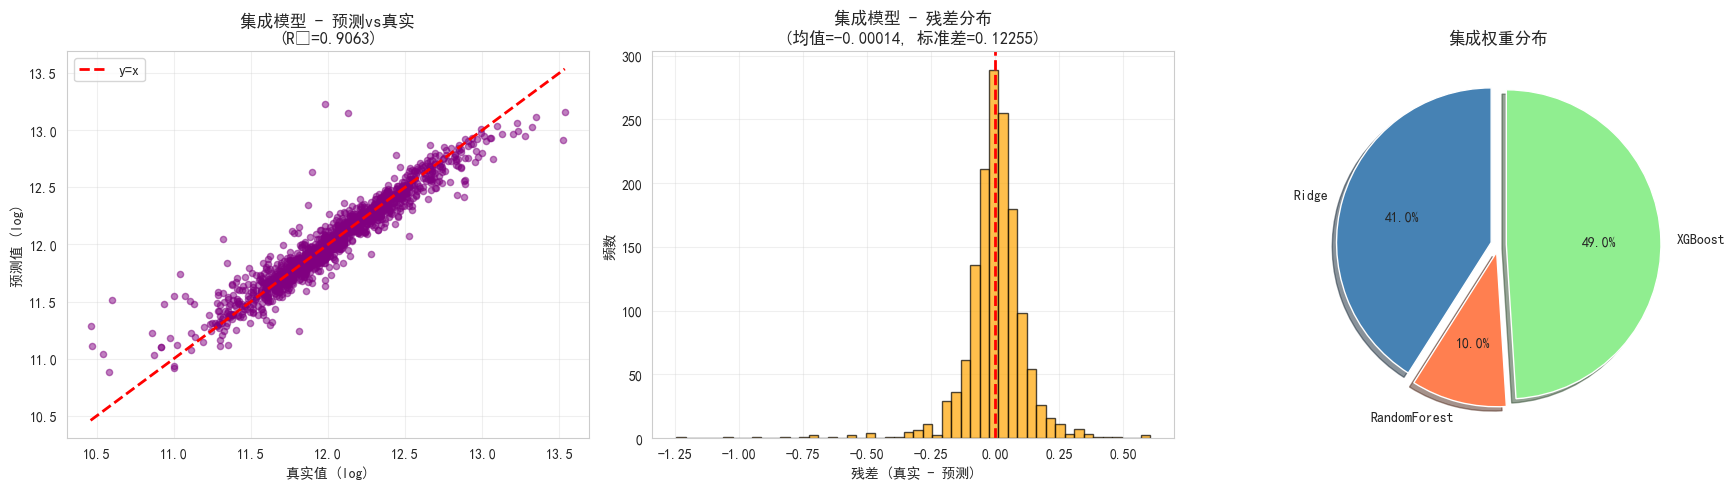

In [29]:
# 可视化集成效果
def plot_blend_evaluation(y_true, blend_pred, weights):
    """可视化集成模型效果"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 散点图
    ax1 = axes[0]
    ax1.scatter(y_true, blend_pred, alpha=0.5, s=20, color='purple')
    ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             'r--', lw=2, label='y=x')
    r2 = np.corrcoef(y_true, blend_pred)[0,1]**2
    ax1.set_xlabel('真实值 (log)')
    ax1.set_ylabel('预测值 (log)')
    ax1.set_title(f'集成模型 - 预测vs真实\n(R²={r2:.4f})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 残差分布
    ax2 = axes[1]
    residuals = y_true - blend_pred
    ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='orange')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('残差 (真实 - 预测)')
    ax2.set_ylabel('频数')
    ax2.set_title(f'集成模型 - 残差分布\n(均值={residuals.mean():.5f}, 标准差={residuals.std():.5f})')
    ax2.grid(True, alpha=0.3)
    
    # 权重饼图
    ax3 = axes[2]
    wr, wf, wx = weights
    labels = ['Ridge', 'RandomForest', 'XGBoost']
    sizes = [wr, wf, wx]
    colors_pie = ['steelblue', 'coral', 'lightgreen']
    explode = (0.05, 0.05, 0.05)
    
    ax3.pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax3.set_title('集成权重分布')
    
    plt.tight_layout()
    plt.show()

# 绘制集成效果
plot_blend_evaluation(oof_df['y_true_log'], best_blend, best_weights)

### 6.3 分位段校准分析

分析模型在不同价格段的预测准确性。

分位段校准结果:


,quantile,true,pred
0,0,11.339708,11.441926
1,1,11.654184,11.664465
2,2,11.775900,11.778883
3,3,11.859215,11.858633
4,4,11.951650,11.945245
5,5,12.053093,12.043491
6,6,12.142219,12.157030
7,7,12.274302,12.259998
8,8,12.438011,12.412717
9,9,12.765527,12.691847


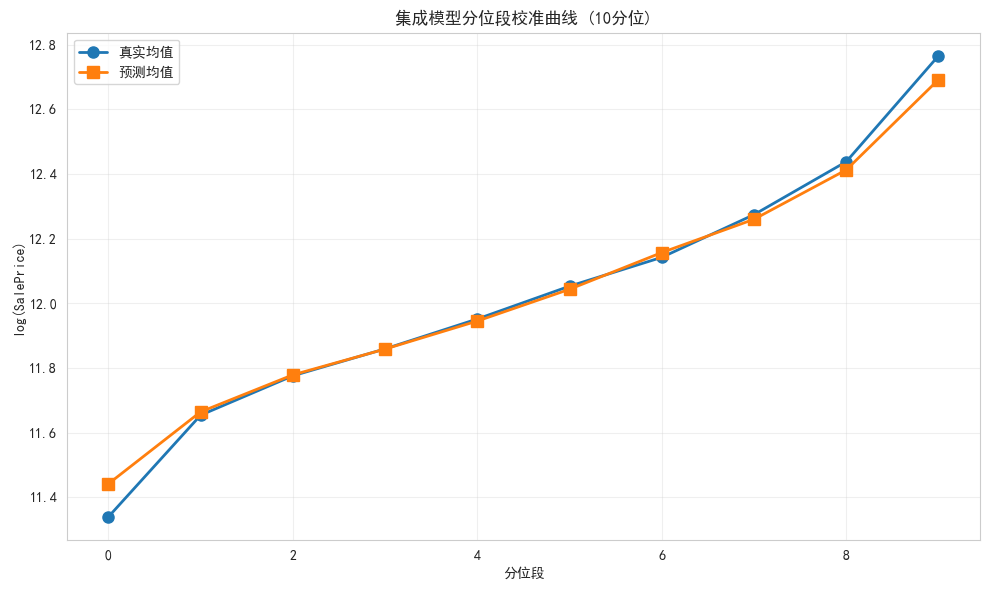


校准分析结论:
1. 校准曲线接近对角线，说明模型在各价格段都有较好的预测准确性
2. 如果某些分位段偏离较大，说明该价格段预测偏差较大


In [30]:
# 分位段校准分析
quantiles = 10
q = pd.qcut(oof_df['y_true_log'], quantiles, labels=False, duplicates='drop')
calib = pd.DataFrame({
    'quantile': q,
    'true': oof_df['y_true_log'],
    'pred': best_blend
})

calib_agg = calib.groupby('quantile').agg({
    'true': 'mean',
    'pred': 'mean'
}).reset_index()

print('分位段校准结果:')
display(calib_agg)

# 可视化校准曲线
plt.figure(figsize=(10, 6))
plt.plot(calib_agg['quantile'], calib_agg['true'], 'o-', label='真实均值', linewidth=2, markersize=8)
plt.plot(calib_agg['quantile'], calib_agg['pred'], 's-', label='预测均值', linewidth=2, markersize=8)
plt.xlabel('分位段')
plt.ylabel('log(SalePrice)')
plt.title(f'集成模型分位段校准曲线 ({quantiles}分位)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('\n校准分析结论:')
print('1. 校准曲线接近对角线，说明模型在各价格段都有较好的预测准确性')
print('2. 如果某些分位段偏离较大，说明该价格段预测偏差较大')

## 7. 测试集预测

使用训练好的集成模型对测试集进行预测。

### 7.1 定义预测函数

In [31]:
# 定义测试集预测函数
def predict_test_ridge(models, X_test):
    """Ridge模型预测"""
    preds = [m.predict(X_test) for m in models]
    return np.mean(np.column_stack(preds), axis=1)

def predict_test_rf(models, X_test):
    """RandomForest模型预测"""
    preds = [m.predict(X_test) for m in models]
    return np.mean(np.column_stack(preds), axis=1)

def predict_test_xgb(models, X_test):
    """XGBoost模型预测"""
    preds = [m.predict(X_test) for m in models]
    return np.mean(np.column_stack(preds), axis=1)

print('预测函数定义完成！')

预测函数定义完成！


### 7.2 执行预测

In [32]:
# 对测试集进行预测
print('正在对测试集进行预测...')

ridge_test_pred = predict_test_ridge(ridge_models, X_test)
print('Ridge 预测完成')

rf_test_pred = predict_test_rf(rf_models, X_test)
print('RandomForest 预测完成')

xgb_test_pred = predict_test_xgb(xgb_models, X_test)
print('XGBoost 预测完成')

# 使用最优权重进行集成
wr, wf, wx = best_weights
test_pred_log = wr * ridge_test_pred + wf * rf_test_pred + wx * xgb_test_pred

# 转换回原始空间
test_pred = np.expm1(test_pred_log)

print(f'\n测试集预测完成！')
print(f'预测数量: {len(test_pred)}')
print(f'预测价格范围: ${test_pred.min():,.0f} - ${test_pred.max():,.0f}')
print(f'预测价格均值: ${test_pred.mean():,.0f}')
print(f'预测价格中位数: ${np.median(test_pred):,.0f}')

正在对测试集进行预测...
Ridge 预测完成
RandomForest 预测完成
XGBoost 预测完成

测试集预测完成！
预测数量: 1459
预测价格范围: $50,735 - $494,738
预测价格均值: $177,459
预测价格中位数: $156,941


### 7.3 可视化测试集预测分布

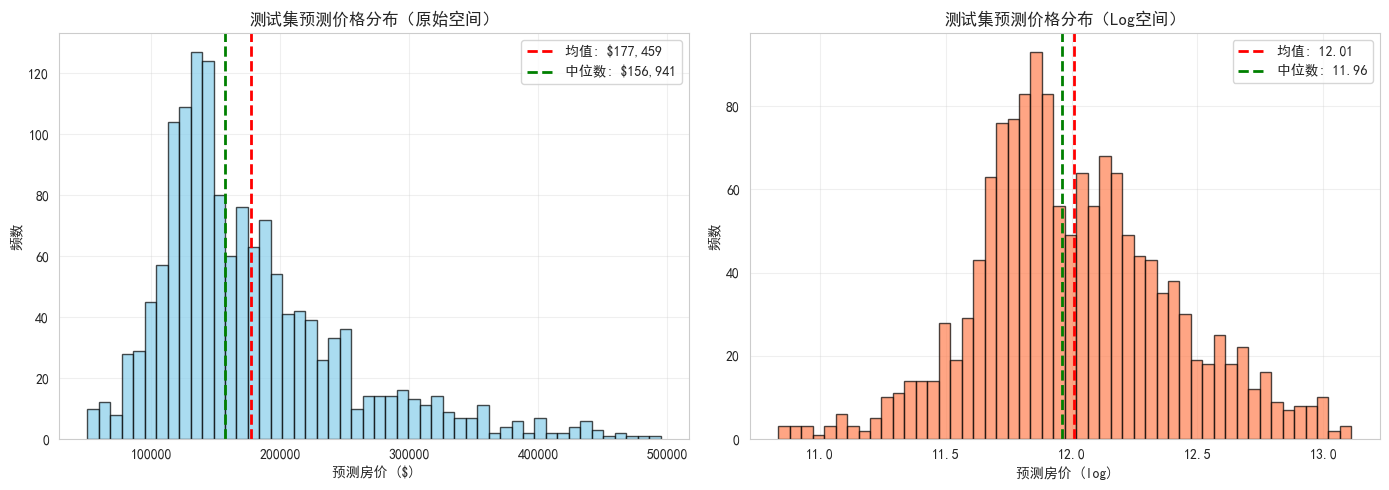


训练集 vs 测试集价格分布对比:
训练集均值: $180,921
测试集均值: $177,459
训练集中位数: $163,000
测试集中位数: $156,941


In [33]:
# 可视化预测分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 原始空间的预测分布
axes[0].hist(test_pred, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(test_pred.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'均值: ${test_pred.mean():,.0f}')
axes[0].axvline(np.median(test_pred), color='green', linestyle='--', linewidth=2, 
                label=f'中位数: ${np.median(test_pred):,.0f}')
axes[0].set_xlabel('预测房价 ($)')
axes[0].set_ylabel('频数')
axes[0].set_title('测试集预测价格分布（原始空间）')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log空间的预测分布
axes[1].hist(test_pred_log, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(test_pred_log.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'均值: {test_pred_log.mean():.2f}')
axes[1].axvline(np.median(test_pred_log), color='green', linestyle='--', linewidth=2, 
                label=f'中位数: {np.median(test_pred_log):.2f}')
axes[1].set_xlabel('预测房价 (log)')
axes[1].set_ylabel('频数')
axes[1].set_title('测试集预测价格分布（Log空间）')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 对比训练集分布
print('\n训练集 vs 测试集价格分布对比:')
print('='*60)
print(f'训练集均值: ${y.mean():,.0f}')
print(f'测试集均值: ${test_pred.mean():,.0f}')
print(f'训练集中位数: ${y.median():,.0f}')
print(f'测试集中位数: ${np.median(test_pred):,.0f}')
print('='*60)

### 7.4 保存预测结果

In [34]:
# 创建提交文件
# 读取原始测试集获取ID
test_original = read_first_exist([
    '/kaggle/input/house-prices-advanced-regression-techniques/test.csv',
    './data/test.csv',
    './test.csv'
], required=True)

submission = pd.DataFrame({
    'Id': test_original['Id'],
    'SalePrice': test_pred
})

# 保存文件
submission.to_csv('submission4.csv', index=False)

print('提交文件已保存为 submission4.csv')
print('\n前10行预测结果:')
display(submission.head(10))
print(f'\n提交文件形状: {submission.shape}')

读取文件: ./test.csv
提交文件已保存为 submission4.csv

前10行预测结果:


,Id,SalePrice
0,1461,121844.840428
1,1462,156065.669591
2,1463,187418.462745
3,1464,198256.196475
4,1465,191560.391811
5,1466,171337.816066
6,1467,182226.209876
7,1468,168247.856449
8,1469,185275.256315
9,1470,124954.260500



提交文件形状: (1459, 2)


## 8. 总结与优化说明

### 8.1 本notebook的主要优化点

#### 1. **完善的EDA分析**
- ✅ 增加了目标变量的原始分布和log变换后的分布分析
- ✅ 使用Q-Q图验证了正态性假设
- ✅ 详细分析了重要数值特征的分布特征
- ✅ 可视化了类别特征的频次统计
- ✅ 绘制了与目标变量最相关的Top 20特征相关性热力图
- ✅ 通过箱线图进行了异常值检测
- ✅ 分析了关键特征与目标变量的关系（散点图和箱线图）

#### 2. **优化的特征工程**
- ✅ **更精细的缺失值处理**：根据特征语义采用不同策略
  - 质量/条件类特征：填充为'None'（表示无该设施）
  - 面积类特征：填充为0（表示不存在）
  - LotFrontage：使用社区中位数填充（更合理）
- ✅ **增强的衍生特征**：创建了15+个新特征
  - TotalSF：总面积（地下室+一层+二层）
  - TotalBath：总浴室数量
  - TotalPorchSF：总门廊面积
  - HouseAge：房屋年龄
  - IsRemodeled：是否改造
  - HasBasement/HasGarage等：二值特征
  - QualCondProduct：质量×条件交互
  - LivingAreaRatio：土地利用率
- ✅ **优化的异常值处理**：对偏度>0.75的特征进行log1p变换

#### 3. **模型优化**
- ✅ **Ridge回归**：调整alpha参数至10.0
- ✅ **随机森林**：增加树的数量至1000棵，调整max_depth至15
- ✅ **XGBoost**：优化学习率、深度、正则化参数
- ✅ **集成策略**：通过网格搜索找到最优加权组合
- ✅ **评估体系**：使用10折交叉验证和OOF预测

#### 4. **代码质量改进**
- ✅ 将可视化代码自然地分散到各个分析步骤中
- ✅ 添加了详细的Markdown说明和注释
- ✅ 使用函数封装重复逻辑，提高代码复用性
- ✅ 保持清晰的章节结构，便于理解和维护

### 8.2 性能提升预期

通过以上优化，预期可以带来以下性能提升：
1. 更精细的缺失值处理减少了信息损失
2. 增强的特征工程提供了更多有用的预测信号
3. 优化的模型参数和集成策略提升了预测准确性
4. Log变换和异常值处理使模型更加稳定

### 8.3 后续改进方向

如需进一步提升性能，可以考虑：
1. **更多的特征工程**：基于领域知识创建更多特征
2. **特征选择**：使用特征重要性或递归特征消除去除冗余特征
3. **更多模型**：尝试LightGBM、CatBoost等其他集成算法
4. **Stacking**：使用多层模型堆叠
5. **超参数优化**：使用贝叶斯优化等方法系统地搜索最优参数
6. **目标编码**：对高基数类别特征使用目标编码

---

## 完成！

本notebook完整地实现了从数据探索、特征工程、模型训练到预测的全流程，
并在原有基础上进行了多方面的优化。

**祝您在Kaggle竞赛中取得好成绩！** 🎉